# Import Library

In [1]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 3.8 MB/s eta 0:00:00


In [2]:
#EDA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import urllib.request
from pandas.plotting import scatter_matrix

#Data Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

# Modelling
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from skopt import BayesSearchCV
from skopt.space import Integer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import time

# Data Understanding

## Import Data

In [3]:
# Uplode Your Kaggle Json FIle
from google.colab import files
files.upload()
print ('File uploded!')

Saving kaggle.json to kaggle.json
File uploded!


In [4]:
# Set Up Kaggle.json
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# Import Dataset From Kaggle
!kaggle datasets download -d camnugent/california-housing-prices --unzip

Dataset URL: https://www.kaggle.com/datasets/camnugent/california-housing-prices
License(s): CC0-1.0
  0% 0.00/400k [00:00<?, ?B/s]
100% 400k/400k [00:00<00:00, 619MB/s]


In [6]:
#Load Dataset
df = pd.read_csv('/content/housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [7]:
df['ocean_proximity'].value_counts()

,count
ocean_proximity,
<1H OCEAN,9136
INLAND,6551
NEAR OCEAN,2658
NEAR BAY,2290
ISLAND,5


## 🏡 **California Housing Prices Dataset — Overview**

#### 📚 Dataset Background

This dataset is used in **Chapter 2** of *Hands-On Machine Learning with Scikit-Learn and TensorFlow* by **Aurélien Géron**.

It’s ideal for beginners because:

* The size is just right — not too small, not overwhelming
* The features are intuitive and easy to understand
* Only basic data cleaning is needed

Although the data is from the **1990 California Census** (so it's outdated for current housing market predictions), it’s perfect for learning the **fundamentals of machine learning**, especially regression tasks.

---

#### 📦 Dataset Features (Columns Explained)

| Feature            | Description                                                                            |
| ------------------ | -------------------------------------------------------------------------------------- |
| `longitude`        | How far west the block is located; higher = further west                               |
| `latitude`         | How far north the block is located; higher = further north                             |
| `housingMedianAge` | Median age of houses in the block; lower = newer buildings                             |
| `totalRooms`       | Total number of rooms in the block (not just per house)                                |
| `totalBedrooms`    | Total number of bedrooms in the block                                                  |
| `population`       | Total number of people living in the block                                             |
| `households`       | Total number of households in the block (household = group in a housing unit)          |
| `medianIncome`     | Median income in the block (measured in tens of thousands of USD; e.g. 3.5 = \$35,000) |
| `medianHouseValue` | Median house value in the block (in USD)                                               |
| `oceanProximity`   | Proximity of the block to the ocean (categories like ‘NEAR OCEAN’, ‘INLAND’)           |


## 🔍 EDA → **For Splitting Data**

**Why we split the data before doing EDA**

Before we perform exploratory data analysis (EDA), it’s very important to split the dataset into a training set and a test set first. Why? Because we want to avoid **data leakage**—a situation where information from the test set accidentally influences the training process.

If we do EDA (including visualization, preprocessing, scaling, and feature engineering) on the **entire dataset before splitting**, we risk leaking information from the test set into the model. This can make the model look very accurate during evaluation, but its performance might **drop significantly in the real world** because it has already “peeked” at the answers.

**So, what should we do?**

* Split the data first, usually in an 80:20 ratio (80% for training, 20% for testing).
* Keep the test set **completely untouched**—no EDA, no preprocessing.
* To preserve the distribution of important features like `median_income`, use **stratified sampling** instead of random splitting.

**Why this matters**

By doing EDA, preprocessing, and modeling **only on the training set**, we make sure the model is:

* Valid and unbiased
* More realistic in its predictions
* Better prepared for unseen, real-world data

#### Check Data Information

In [8]:
#Overall Data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


There are missing values in the total_bedrooms column. This issue will be handled later during the data preprocessing stage.



In [9]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


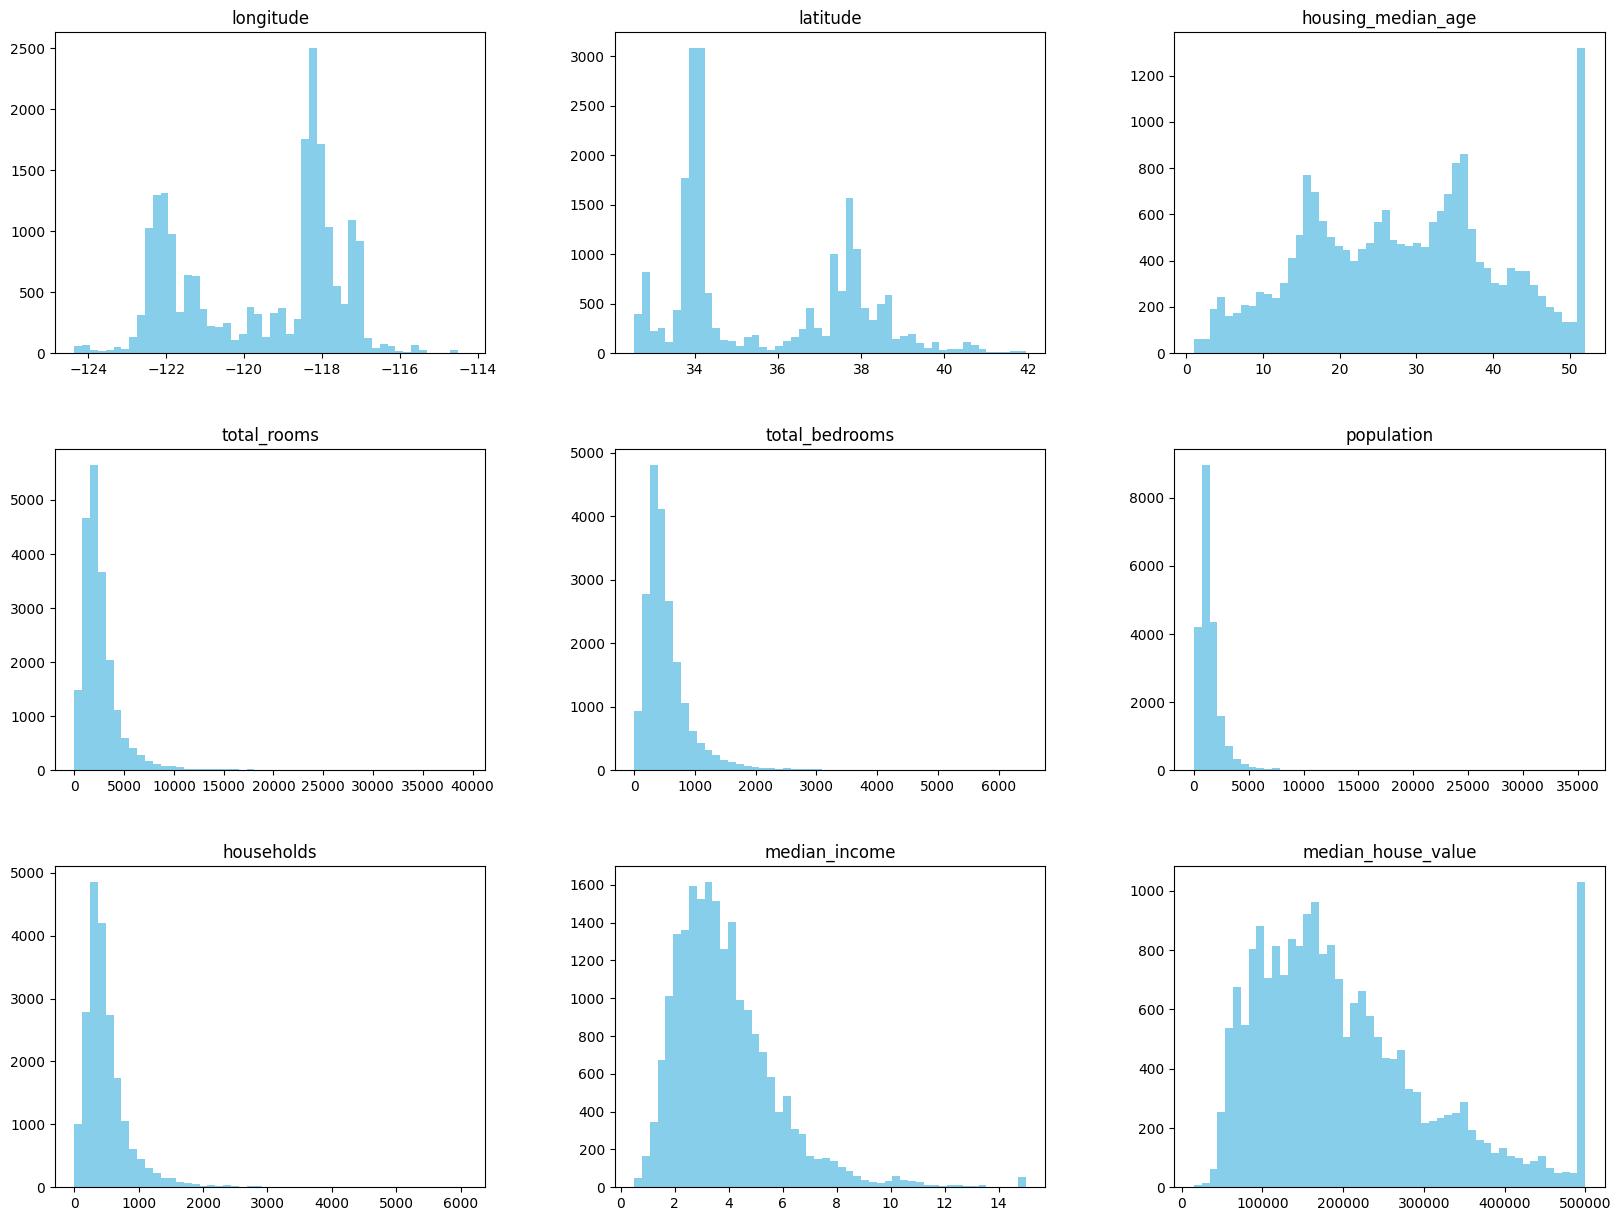

In [ ]:
df.hist(
    bins=50,
    figsize=(20,15),
    grid=False,
    color='skyblue')
plt.show()

* **DATA DISTRIBUTION INSIGTH**

  **1. Median Income is Scaled (Not Raw USD)**

  * The `median_income` feature **isn’t in dollars**.
  * It’s been **scaled between \~0.5 to \~15**.
  * Example:
    `3.0` ≈ `$30,000` income
    `15.0` is the **cap** → any higher values are squished to this max.
  * ⚠️ It’s common in ML to work with preprocessed data like this, but you should **understand how it was scaled**.

  ---

  **2. Target (`median_house_value`) is Capped at \$500,000**

  * Any house values **above \$500,000** were capped at that amount.
  * ⚠️ This can be a problem, especially since it's your **target variable**.
  * If your ML model needs to predict beyond \$500,000:

  You have 2 choices:

  * **Option A**: Find real house values for those capped districts (get better labels).
  * **Option B**: Remove those rows from your dataset (train/test), so your model won’t get confused or be penalized.

  ---

  **3. Feature Scaling is Needed**

  * The features like income, age, and number of rooms have **different scales**.
  * This can mess with some algorithms (like KNN, Logistic Regression, etc).
  * ✅ You’ll need to apply **feature scaling** (like `StandardScaler` or `MinMaxScaler`).

  ---

  **4. Skewed Distributions (Tail Heavy)**

  * Many features have **long right tails** (positively skewed).
  * This makes it harder for some algorithms to detect patterns.

  **Solution:**

  You can apply transformations like:

  * **log transform**, **sqrt**, or **Box-Cox** to make the data more **bell-shaped** (normal distribution-ish).


* **CHECK CORRELATION BETWEEN FEATURE & TARGET**

In [10]:
corr = df.corr(numeric_only=True)
print('Correlation Matrix')
corr['median_house_value'].sort_values(ascending=False)

Correlation Matrix


,median_house_value
median_house_value,1.000000
median_income,0.688075
total_rooms,0.134153
housing_median_age,0.105623
households,0.065843
total_bedrooms,0.049686
population,-0.024650
longitude,-0.045967
latitude,-0.144160


From the data exploration, we can see that the strongest feature for predicting the target median_house_value is median_income—the median income of people living in California.

Because of its strong influence, we’ll use the median_income feature as a reference during the splitting/sampling process.

The goal is to avoid bias toward groups of data that have larger populations. So, we will split the data into 80% for training and 20% for testing, and apply stratified sampling. This technique makes sure the distribution of median_income stays balanced in both sets, helping the model become more fair and generalizable.



### Data Split Using **Stratified Sampling**

<Axes: >

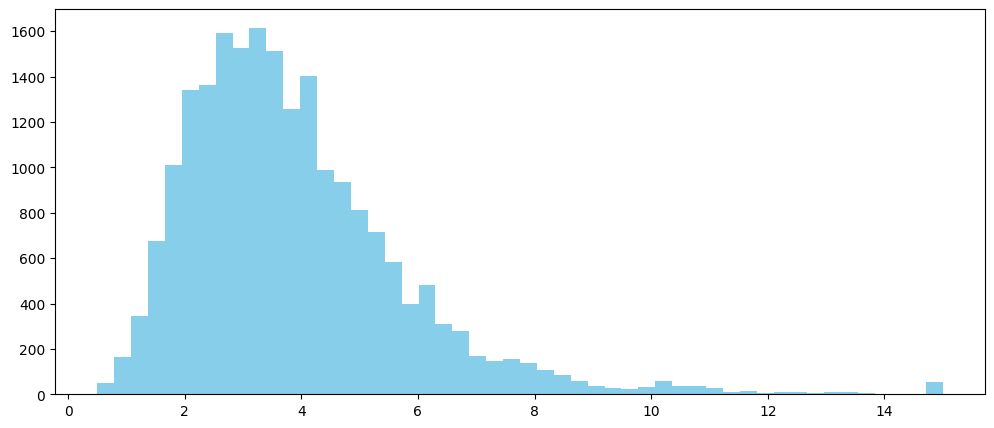

In [11]:
df['median_income'].hist(
    bins=50,
    figsize=(12,5),
    grid=False,
    color='skyblue')


After observing the distribution of values in the `median_income` column, we can see that **most of California's population has a median income between 1.5 and 6**, which roughly equals **\$15,000–\$60,000 USD** (since `median_income` represents tens of thousands of dollars).

To make the **stratified sampling** more accurate and balanced, we’ll create a new feature called **`cat_medincome`**, which converts the numerical `median_income` values into **categories (ranges)**. These categories represent income groups and will be used as the basis for stratified splitting.

**📦 Income Categories:**

* **0** : `median_income` < 1.5
* **1** : 1.5 ≤ `median_income` < 3.0
* **2** : 3.0 ≤ `median_income` < 4.5
* **3** : 4.5 ≤ `median_income` < 6.0
* **4** : `median_income` ≥ 6.0

By doing this, we ensure that the proportion of each income group stays balanced in both the training and test sets, helping us **avoid bias toward any specific group**.

> 📌 Note: After the splitting is done, the `cat_medincome` column will **not be used for training** the model and can be safely removed.


**Create Medincome Feature to split the data using stratified sampling.**

In [12]:
df['medincome'] = pd.cut(df['median_income'],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])
df.medincome.value_counts()

,count
medincome,
3,7236
2,6581
4,3639
5,2362
1,822


After splitting the data into 5 categories, here’s the distribution of `median_income` per category:

| Category (Label) | Median Income Range | Row Count | 💡 Interpretation                                                          |
| ---------------- | ------------------- | --------- | -------------------------------------------------------------------------- |
| `3`              | 3.0 – 4.5           | **7,236** | This is the **largest group** — most Californians earn between \$30K–\$45K |
| `2`              | 1.5 – 3.0           | **6,581** | Income between \$15K–\$30K, also a large group                             |
| `4`              | 4.5 – 6.0           | **3,639** | Income between \$45K–\$60K                                                 |
| `5`              | > 6.0 (above \$60K) | **2,362** | High income, but a smaller population                                      |
| `1`              | < 1.5 (under \$15K) | **822**   | Lowest income group, relatively small                                      |

**Further interpretation:**

* The income distribution is **not balanced** — most people are in the middle categories (2 and 3).
* That’s why using **stratified sampling** based on `median_income` is so important: it makes sure smaller groups (like 1 and 5) are still represented in both the training and test sets.
* If you use random splitting, minority groups like category 1 might not show up at all in the test set, which would make your model **less generalizable**.


In [13]:
print('Proportion Presentation in All class medincome :')
df['medincome'].value_counts(normalize=True) *100

Proportion Presentation in All class medincome :


,proportion
medincome,
3,35.058140
2,31.884690
4,17.630814
5,11.443798
1,3.982558


In [14]:
# Stratified Sampling Initiate
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Split Using Medincome
for train_index, test_index in split.split(df, df["medincome"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

okay, the splitting process was done and we split to 2 different var. next steps we have to analize train set to make sure everythings is clean and raady to use in modelling process.

### Check the  Data After Splitting

In [15]:
print('Train Data Count: ', strat_train_set.shape)
print('Test Data Count : ', strat_test_set.shape)

Train Data Count:  (16512, 11)
Test Data Count :  (4128, 11)


In [16]:
# Train Data Proportion Medincome
print('\nProportion Train Data medincome: ')
strat_train_set['medincome'].value_counts()


Proportion Train Data medincome: 


,count
medincome,
3,5789
2,5265
4,2911
5,1890
1,657


In [17]:
# Train Data Proportion Medincome in percent
print('\nProportion Train Data medincome in percent: ')
strat_train_set['medincome'].value_counts(normalize=True) *100


Proportion Train Data medincome in percent: 


,proportion
medincome,
3,35.059351
2,31.885901
4,17.629603
5,11.446221
1,3.978924


In [18]:
# Test Data Proportion Medincome
print('\nProporsi Data Test berdasarkan medincome: ')
strat_test_set['medincome'].value_counts()


Proporsi Data Test berdasarkan medincome: 


,count
medincome,
3,1447
2,1316
4,728
5,472
1,165


In [19]:
# Test Data Proportion Medincome in percent
print('\nProporsi Data Test berdasarkan medincome: ')
strat_test_set['medincome'].value_counts(normalize=True) *100


Proporsi Data Test berdasarkan medincome: 


,proportion
medincome,
3,35.053295
2,31.879845
4,17.635659
5,11.434109
1,3.997093


After splitting the data using **StratifiedShuffleSplit** based on the `medincome` feature, we can see that the **distribution of each category remains consistent** between the training and test sets. This shows that the stratified sampling process worked well and produced a **representative split**.

**📊 Number of Rows in Each Set:**

* **Training Set:** `(16,512 rows, 11 columns)`
* **Test Set:** `(4,128 rows, 11 columns)`

---

**📦 `medincome` Distribution in the Training Set:**

| `medincome` Category | Count | Percentage (%) |
| -------------------- | ----- | -------------- |
| 3                    | 5,789 | 35.06%         |
| 2                    | 5,265 | 31.90%         |
| 4                    | 2,911 | 17.63%         |
| 5                    | 1,890 | 11.45%         |
| 1                    | 657   | 3.98%          |

---

**📦 `medincome` Distribution in the Test Set:**

| `medincome` Category | Count | Percentage (%) |
| -------------------- | ----- | -------------- |
| 3                    | 1,447 | 35.05%         |
| 2                    | 1,316 | 31.89%         |
| 4                    | 728   | 17.63%         |
| 5                    | 472   | 11.43%         |
| 1                    | 165   | 3.99%          |

---

The `medincome` distribution in both the training and test sets is **very consistent**, matching the original dataset. This is important to ensure that the model we train later will not be biased toward any particular income group.


selanjutkan kita akan menghapus kolom `medincome` karena sudah tidak dibutuhkan lagi.

In [20]:
strat_train_set.drop(columns='medincome', inplace= True)
strat_test_set.drop(columns='medincome', inplace=True)

## **🔍 EDA → Deep Analysis on Train data**

To continue with our analysis, we will use the training data that was previously split and stored in the strat_train_set variable.

To keep the original split data safe and untouched, we’ll create a copy of strat_train_set and store it in a new variable called housing.

This new housing variable will be the one we use for all the upcoming data exploration steps.

In [22]:
housing = strat_train_set.copy()

In [23]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 12655 to 19773
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16354 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   median_house_value  16512 non-null  float64
 9   ocean_proximity     16512 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.4+ MB


**1. Missing Values Analysis**

we already now before, the data is include missing values in `total_bedrooms`, but we have to make sure again using function isna().sum()

In [24]:
print('Missing data count :')
housing.isna().sum()

Missing data count :


,0
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,158
population,0
households,0
median_income,0
median_house_value,0
ocean_proximity,0


there are 158 missing values in 'total_bedrooms`, and next step we have to know first about `total_bedrooms` distribution to make a decision how we handle the missing value.

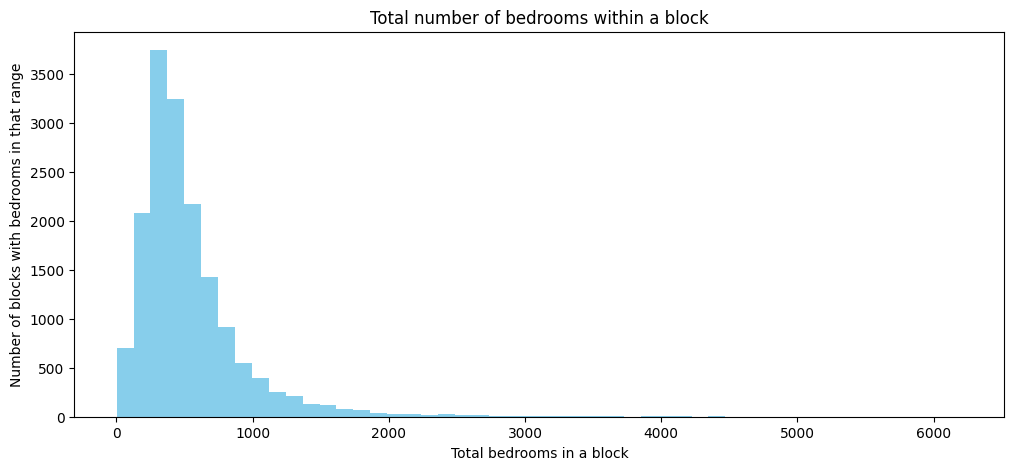

In [25]:
housing['total_bedrooms'].hist(
    bins=50,
    figsize=(12,5),
    grid=False,
    color='skyblue'
)
plt.title("Total number of bedrooms within a block")
plt.xlabel("Total bedrooms in a block")
plt.ylabel("Number of blocks with bedrooms in that range")
plt.show()


Since the data distribution is skewed and not normally distributed, the missing values will be handled using the median instead of the mean.



**2. Geographic Data Analysis**

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           20640 non-null  float64 
 1   latitude            20640 non-null  float64 
 2   housing_median_age  20640 non-null  float64 
 3   total_rooms         20640 non-null  float64 
 4   total_bedrooms      20433 non-null  float64 
 5   population          20640 non-null  float64 
 6   households          20640 non-null  float64 
 7   median_income       20640 non-null  float64 
 8   median_house_value  20640 non-null  float64 
 9   ocean_proximity     20640 non-null  object  
 10  medincome           20640 non-null  category
dtypes: category(1), float64(9), object(1)
memory usage: 1.6+ MB


We have two features that represent geographical information: `latitude` and `longitude`. These features show the location of each house in California.

To visualize how the houses are distributed across the state, I’m going to use a scatter plot — where each dot represents a house based on its geographic coordinates.

This will help us get a better sense of the spatial distribution — like which areas are more densely populated, or how housing trends may differ by location.

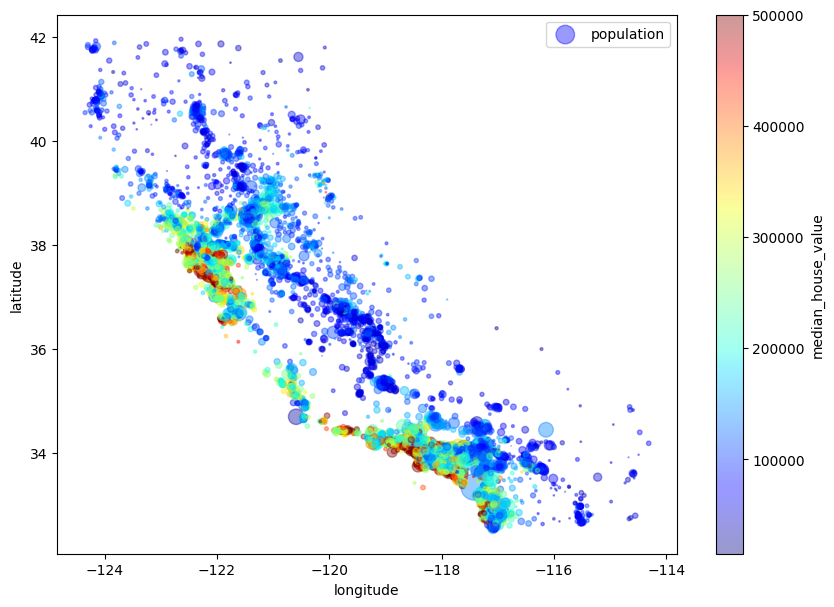

In [27]:
housing.plot(kind="scatter",
             x="longitude",
             y="latitude",
             alpha=0.4,
             s=housing["population"]/100, label="population", figsize=(10,7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,)
plt.legend()

In [28]:
images_path = os.path.join("images", "end_to_end_project")
os.makedirs(images_path, exist_ok=True)

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"
print("Downloading", filename)

url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
target_path = os.path.join(images_path, filename)

urllib.request.urlretrieve(url, target_path)
print("Done! File saved to:", target_path)

Done! File saved to: images/end_to_end_project/california.png


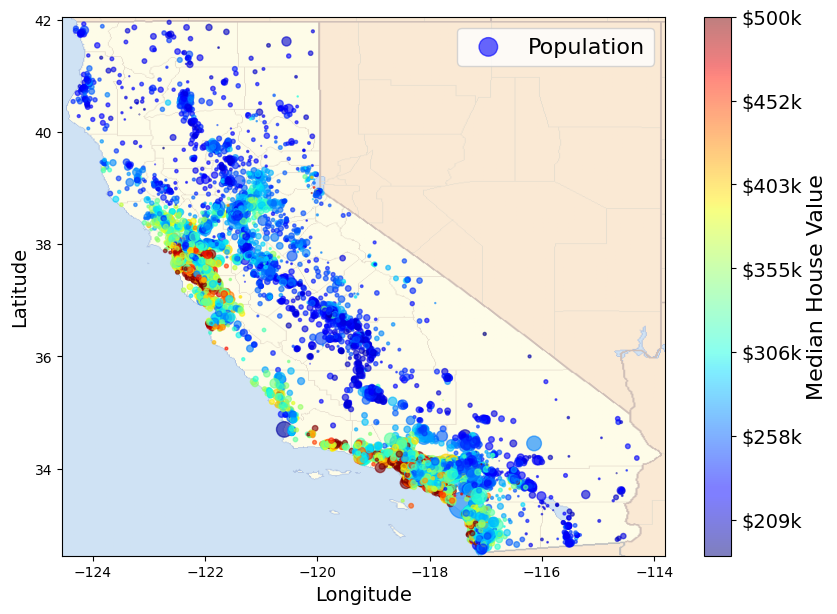

In [29]:
import matplotlib.image as mpimg
california_img=mpimg.imread(os.path.join(images_path, filename))
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                  s=housing['population']/100, label="Population",
                  c="median_house_value", cmap=plt.get_cmap("jet"),
                  colorbar=False, alpha=0.6)
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values/prices.max())
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
plt.show()


- **Location really impacts house prices**
From the scatterplot, it's clear that expensive houses are usually located near the ocean, especially in Southern California. This highlights how geographic location has a strong influence on the median house value.

- **Population density also plays a role**
Larger dots on the plot (which represent higher population) often appear in areas with higher house prices. This suggests that in many cases, densely populated areas tend to have more expensive homes.

- **Clustering could be very helpful**
Since there are visible patterns of high and low price areas, we could use clustering algorithms like K-Means to identify these zones. Then, we can create new features such as:

* Distance to the center of a high-price cluster
* Whether the house is located in a premium zone

These engineered features can improve our model’s understanding of spatial trends.

- **Ocean proximity is helpful, but not everything**
While being near the ocean generally increases house prices, it's not always the case. For example, in Northern California, some coastal areas aren't that expensive. So we shouldn't rely solely on the `ocean_proximity` feature — combining it with other features will give better results.


**3. Correlation Analysis**

In [32]:
housing_corr = housing.corr(numeric_only=True)
print('Correlation Matrix')
housing_corr['median_house_value'].sort_values(ascending=False)

Correlation Matrix


,median_house_value
median_house_value,1.000000
median_income,0.687151
total_rooms,0.135140
housing_median_age,0.114146
households,0.064590
total_bedrooms,0.047781
population,-0.026882
longitude,-0.047466
latitude,-0.142673


array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housi

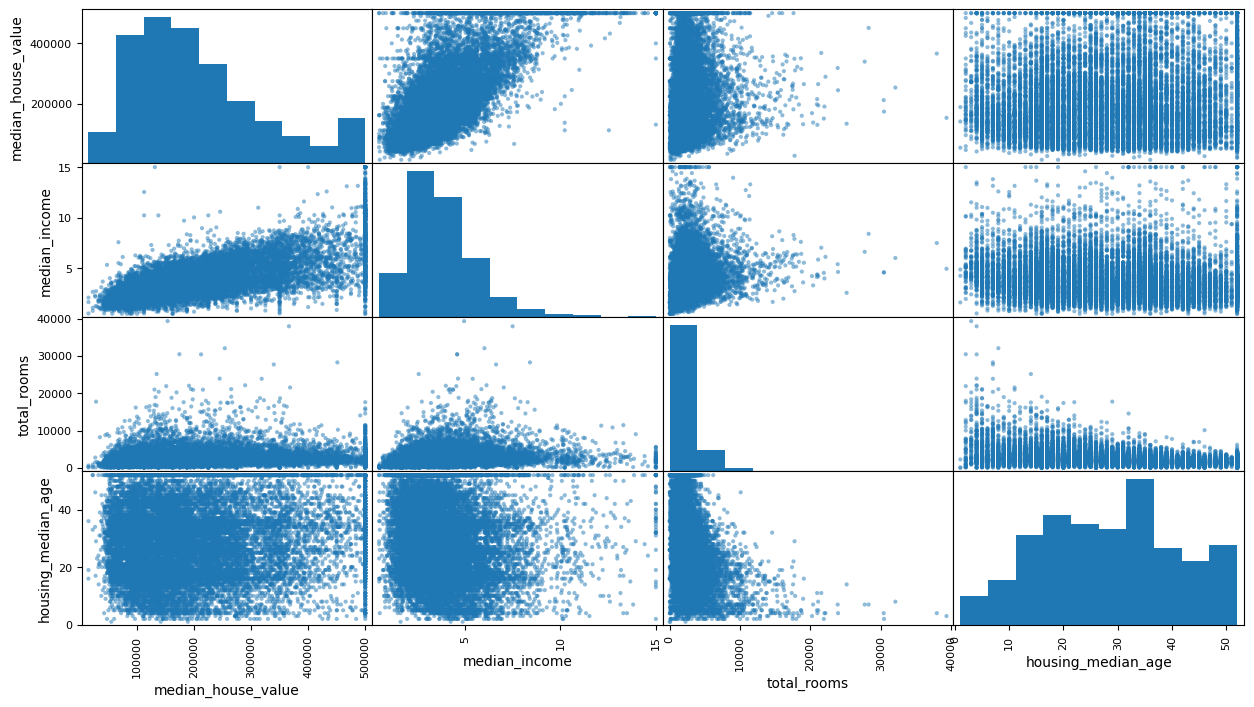

In [34]:
attributes = ["median_house_value", "median_income", "total_rooms",
 "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(15, 8))

<Axes: xlabel='median_income', ylabel='median_house_value'>

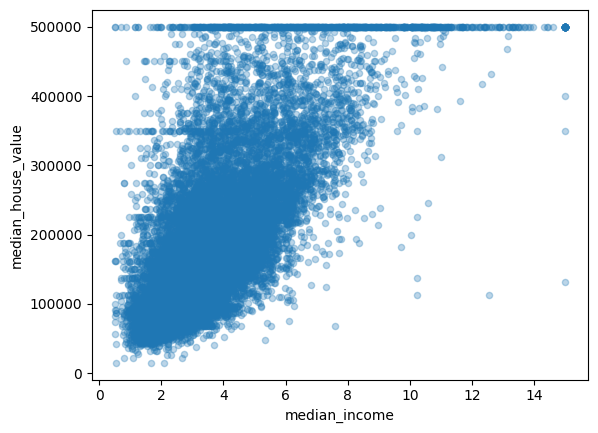

In [36]:
housing.plot(
    kind= 'scatter',
    x = 'median_income',
    y = 'median_house_value',
    alpha = 0.3,
)


After doing further analysis, we found that the feature most strongly correlated with the target variable `median_house_value` is `median_income`.
This means that the **higher the income** in a neighborhood block, the **higher the house prices** tend to be. Makes sense — richer areas usually have more expensive homes.

But there’s something else going on.
We noticed a **capping effect** in the `median_house_value` data — for example, a bunch of values are exactly **\$500,000**, **\$480,000**, or **\$350,000**.
You can see it clearly as **horizontal lines** in the scatterplot, which suggests that some house prices were **capped or limited** at those values.
This kind of artificial limit could impact model training if we don’t handle it properly, since the model might not learn the real relationship for high-end houses.

We also realized that the columns `total_rooms` and `total_bedrooms` represent the **total number of rooms** in a housing block — not per house.
So to make it more useful, we’ll create new features like:

* **Average rooms per household**
* **Average bedrooms per household**

These features will give a more realistic view of housing conditions, and should help the model better understand what's going on at the household level.

**4. Feature Extraction : Create new Valuable feature**

In [37]:
#Ruangan per Rumah
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
#Kamar tidur per rumah
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
#Populasi per Rumah
housing["population_per_household"]=housing["population"]/housing["households"]

In [38]:
housing[['rooms_per_household','bedrooms_per_room', 'population_per_household' ,'ocean_proximity', 'median_house_value']].sample(10)

,rooms_per_household,bedrooms_per_room,population_per_household,ocean_proximity,median_house_value
17090,3.845061,0.270651,2.305358,NEAR OCEAN,272800.0
16983,5.791367,0.173913,3.201439,NEAR BAY,289400.0
8174,5.913947,0.177622,2.623145,<1H OCEAN,244900.0
18181,4.880460,0.200188,2.372414,<1H OCEAN,284800.0
5744,4.486280,0.261298,2.000000,<1H OCEAN,187500.0
15137,6.035963,NaN,2.917633,<1H OCEAN,174400.0
8946,4.582946,0.236806,1.879070,<1H OCEAN,421900.0
20183,3.687500,0.237288,3.571429,NEAR OCEAN,219200.0
11171,5.352697,0.170543,3.597510,<1H OCEAN,218100.0
6643,3.378414,0.291378,3.730819,<1H OCEAN,142300.0


In [39]:
housing_corr = housing.corr(numeric_only=True)
print('Correlation Matrix')
housing_corr['median_house_value'].sort_values(ascending=False)

Correlation Matrix


,median_house_value
median_house_value,1.000000
median_income,0.687151
rooms_per_household,0.146255
total_rooms,0.135140
housing_median_age,0.114146
households,0.064590
total_bedrooms,0.047781
population_per_household,-0.021991
population,-0.026882
longitude,-0.047466


It can be seen that the new feature we created, `rooms_per_household`, has a stronger correlation with `median_house_value` compared to the original `total_rooms` feature.

This likely happens because the **average number of rooms per household** better represents the actual living conditions, rather than just the total number of rooms in a block.

In other words, `rooms_per_household` is a **more relevant and informative feature** for explaining house prices, since it focuses on the **household level**, not the broader block level.

**5. Categorical Column Handling**

In this section, we’re going to process the categorical column `ocean_proximity` using One-Hot Encoding, so that it can be used effectively by our machine learning model.

In [42]:
housing_cat = housing[['ocean_proximity']]

from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 16512 stored elements and shape (16512, 5)>

**See The Result Of One Hot Encoding**

In [43]:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [44]:
housing_cat_1hot[0:10].toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [45]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

Here is the result of applying **One-Hot Encoding** — it returns an array of `0`s and `1`s (or technically `False` and `True`) for each category.

For example, if we look at the following data:

```python
array([[0., 1., 0., 0., 0.]])
```

This means the sample belongs to the **second category**, which in this case is **`INLAND`**, because the value `1.0` (True) appears in the second column of the array.


**6. Handling Skew Distribution**

array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>],
       [<Axes: title={'center': 'rooms_per_household'}>,
        <Axes: title={'center': 'bedrooms_per_room'}>,
        <Axes: title={'center': 'population_per_household'}>]],
      dtype=object)

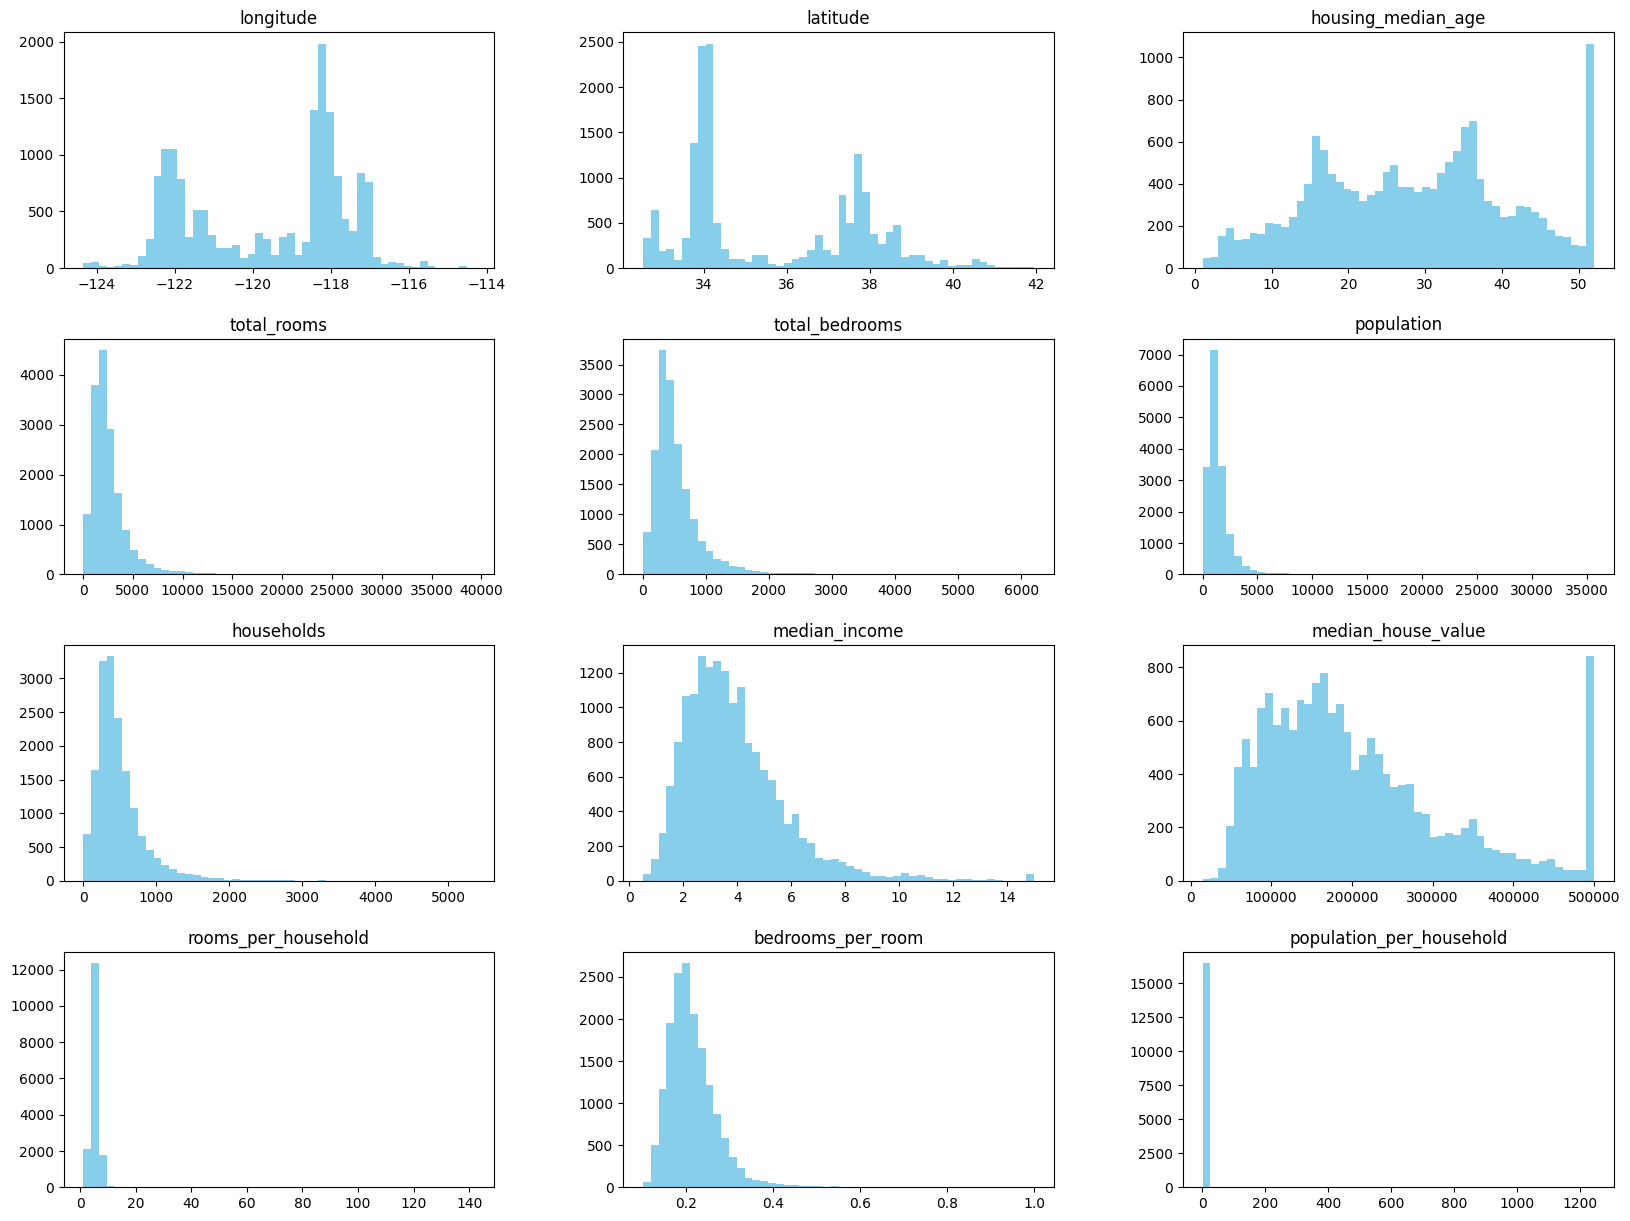

In [46]:
housing.hist(
    bins=50,
    figsize=(20,15),
    grid=False,
    color='skyblue')

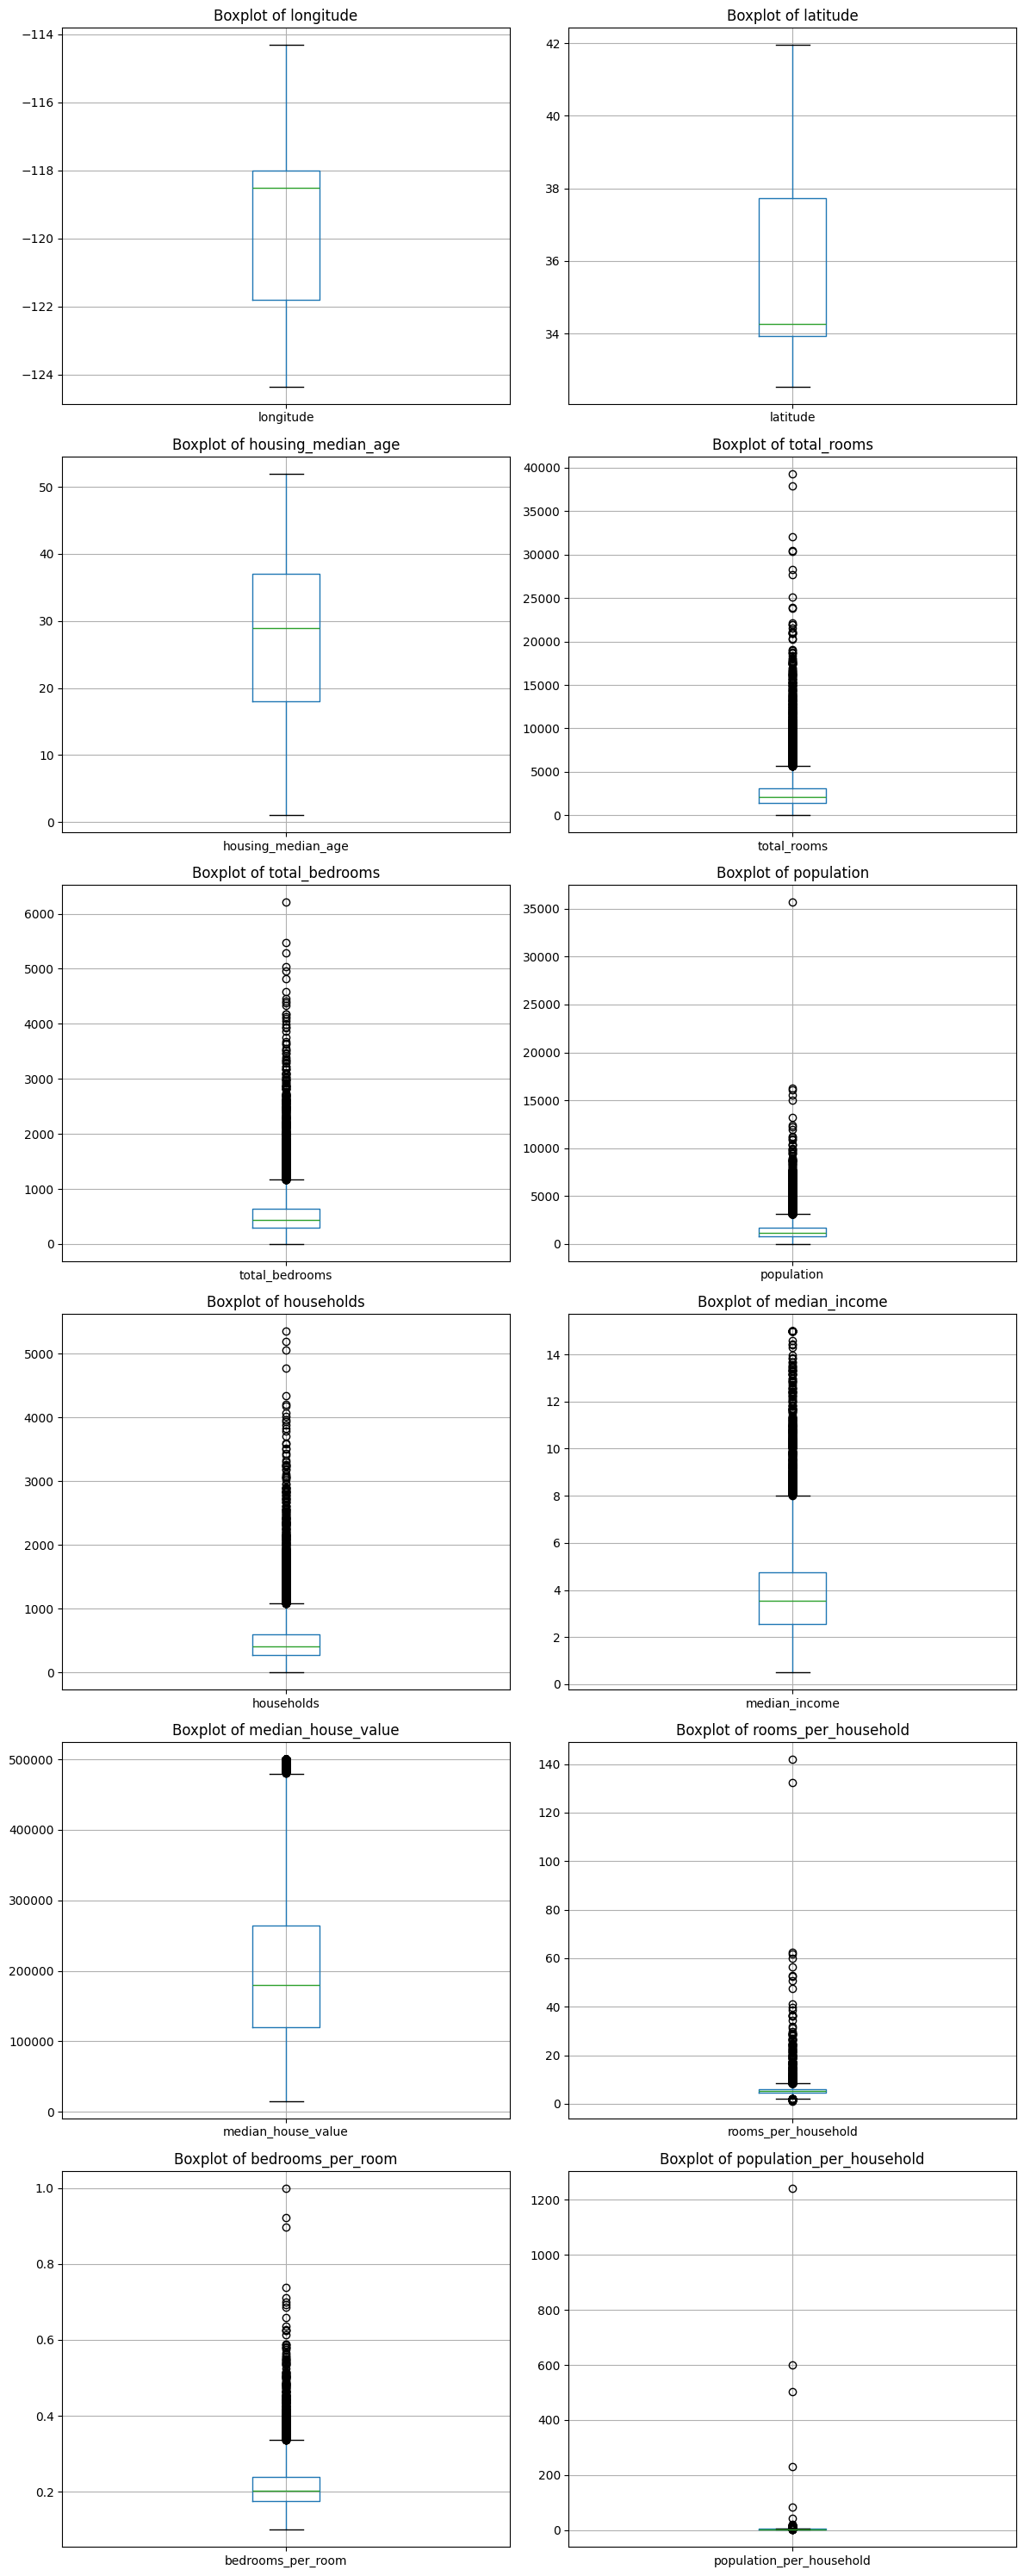

In [51]:
# Select numeric columns
numeric_cols = housing.select_dtypes(include=['float64', 'int64']).columns
num_features = len(numeric_cols)

# Setup 2-column layout
n_cols = 2
n_rows = int(np.ceil(num_features / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5 * n_rows))
axes = axes.flatten()  # flatten to make indexing easier

# Loop and plot each boxplot
for i, col in enumerate(numeric_cols):
    housing.boxplot(column=col, ax=axes[i])
    axes[i].set_title(f"Boxplot of {col}")

# Hide unused subplots (if any)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

- Most of the data distributions are highly skewed, so I decided to handle it by applying data transformation using log1p, followed by scaling the data using a Robust Scaler.

- The log1p transformation helps reduce skewness and makes the distribution closer to normal, especially for features with large positive values.
Meanwhile, RobustScaler is more resistant to outliers compared to standard scaling, making it a better choice after log transformation.



In [53]:
all_columns = housing.columns.tolist()

exclude_columns = ['median_house_value', 'longitude', 'latitude', 'ocean_proximity']

atribut_columns = [col for col in all_columns if col not in exclude_columns]

* **Log1p**

array([[<Axes: title={'center': 'housing_median_age'}>,
        <Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>],
       [<Axes: title={'center': 'population'}>,
        <Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>],
       [<Axes: title={'center': 'rooms_per_household'}>,
        <Axes: title={'center': 'bedrooms_per_room'}>,
        <Axes: title={'center': 'population_per_household'}>]],
      dtype=object)

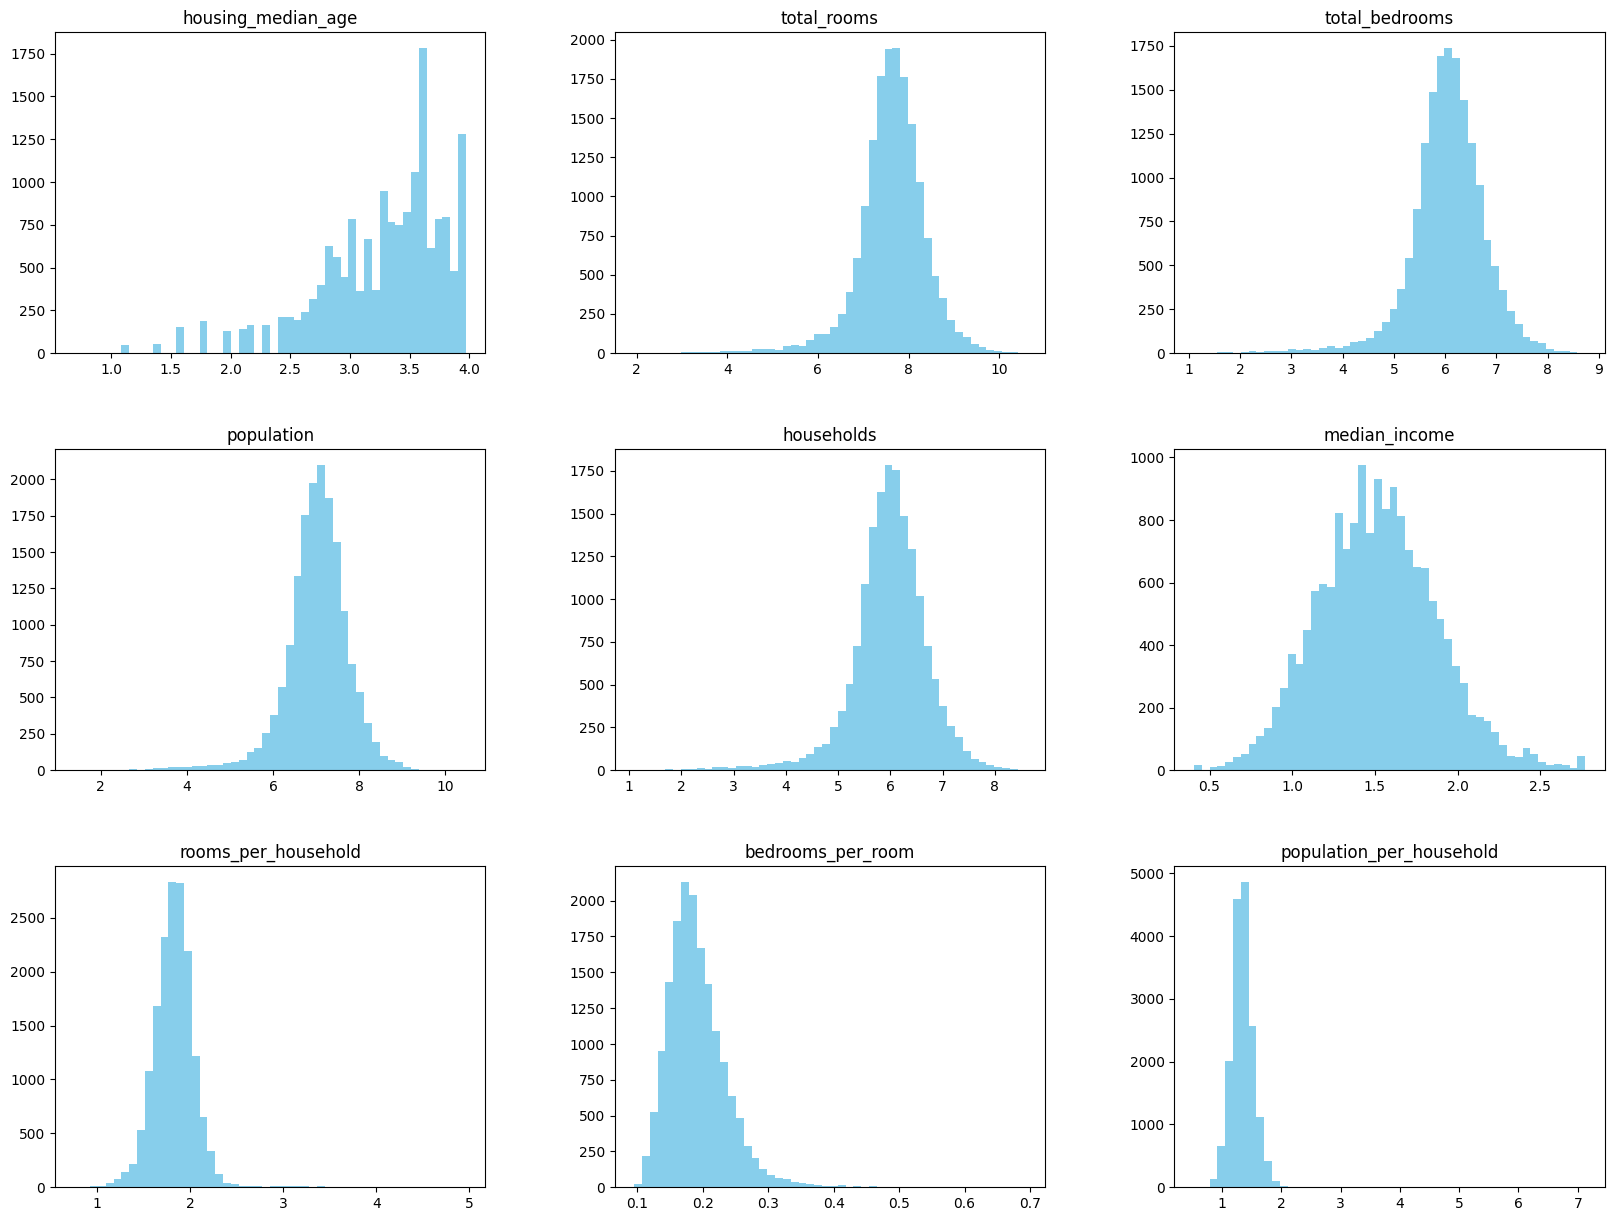

In [54]:
housing_log = np.log1p(housing[atribut_columns])
housing_log.hist(
    bins=50,
    figsize=(20,15),
    grid=False,
    color='skyblue')

In [55]:
sc = RobustScaler()
housing_scaled_array = sc.fit_transform(housing_log)
housing_scaled = pd.DataFrame(housing_scaled_array, columns=atribut_columns, index=housing.index)

In [56]:
housing_ready = pd.concat([
    housing_scaled,
    housing[exclude_columns]
], axis=1)

array([[<Axes: title={'center': 'housing_median_age'}>,
        <Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>],
       [<Axes: title={'center': 'population'}>,
        <Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>],
       [<Axes: title={'center': 'rooms_per_household'}>,
        <Axes: title={'center': 'bedrooms_per_room'}>,
        <Axes: title={'center': 'population_per_household'}>],
       [<Axes: title={'center': 'median_house_value'}>,
        <Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>]], dtype=object)

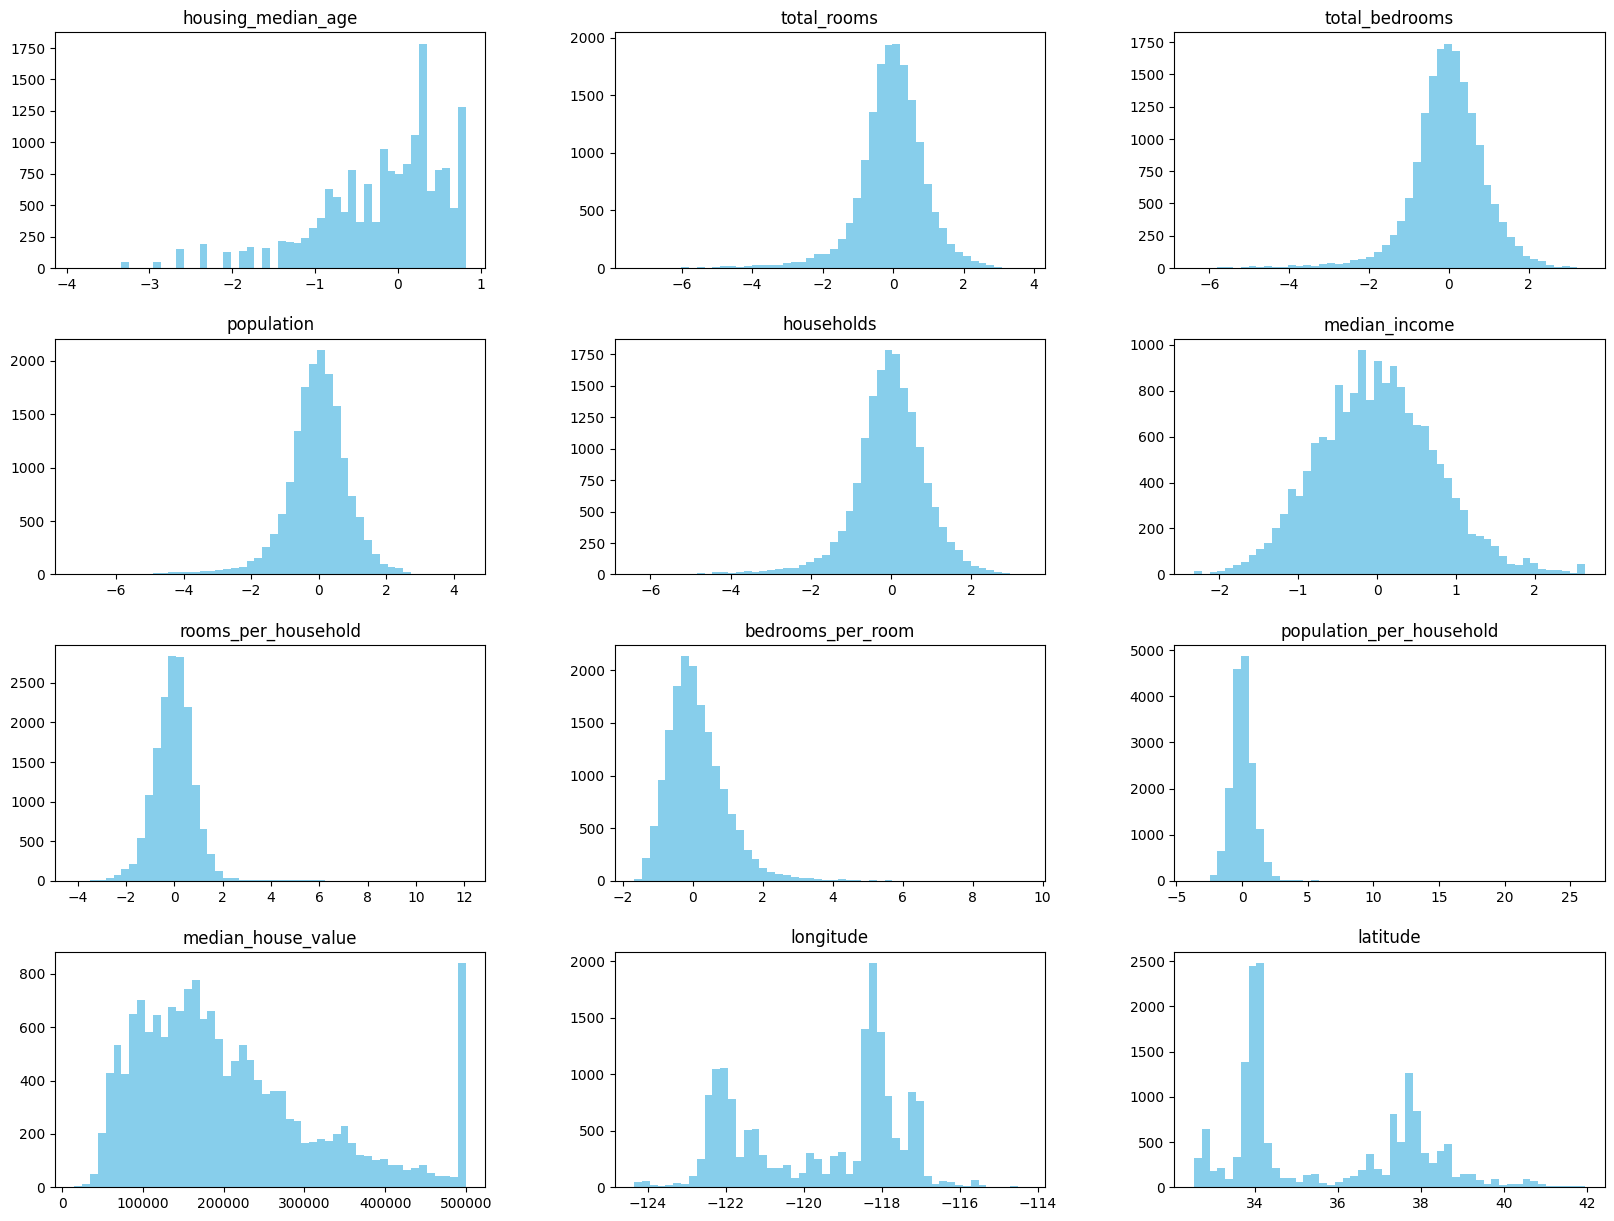

In [57]:
housing_ready.hist(
    bins=50,
    figsize=(20,15),
    grid=False,
    color='skyblue')

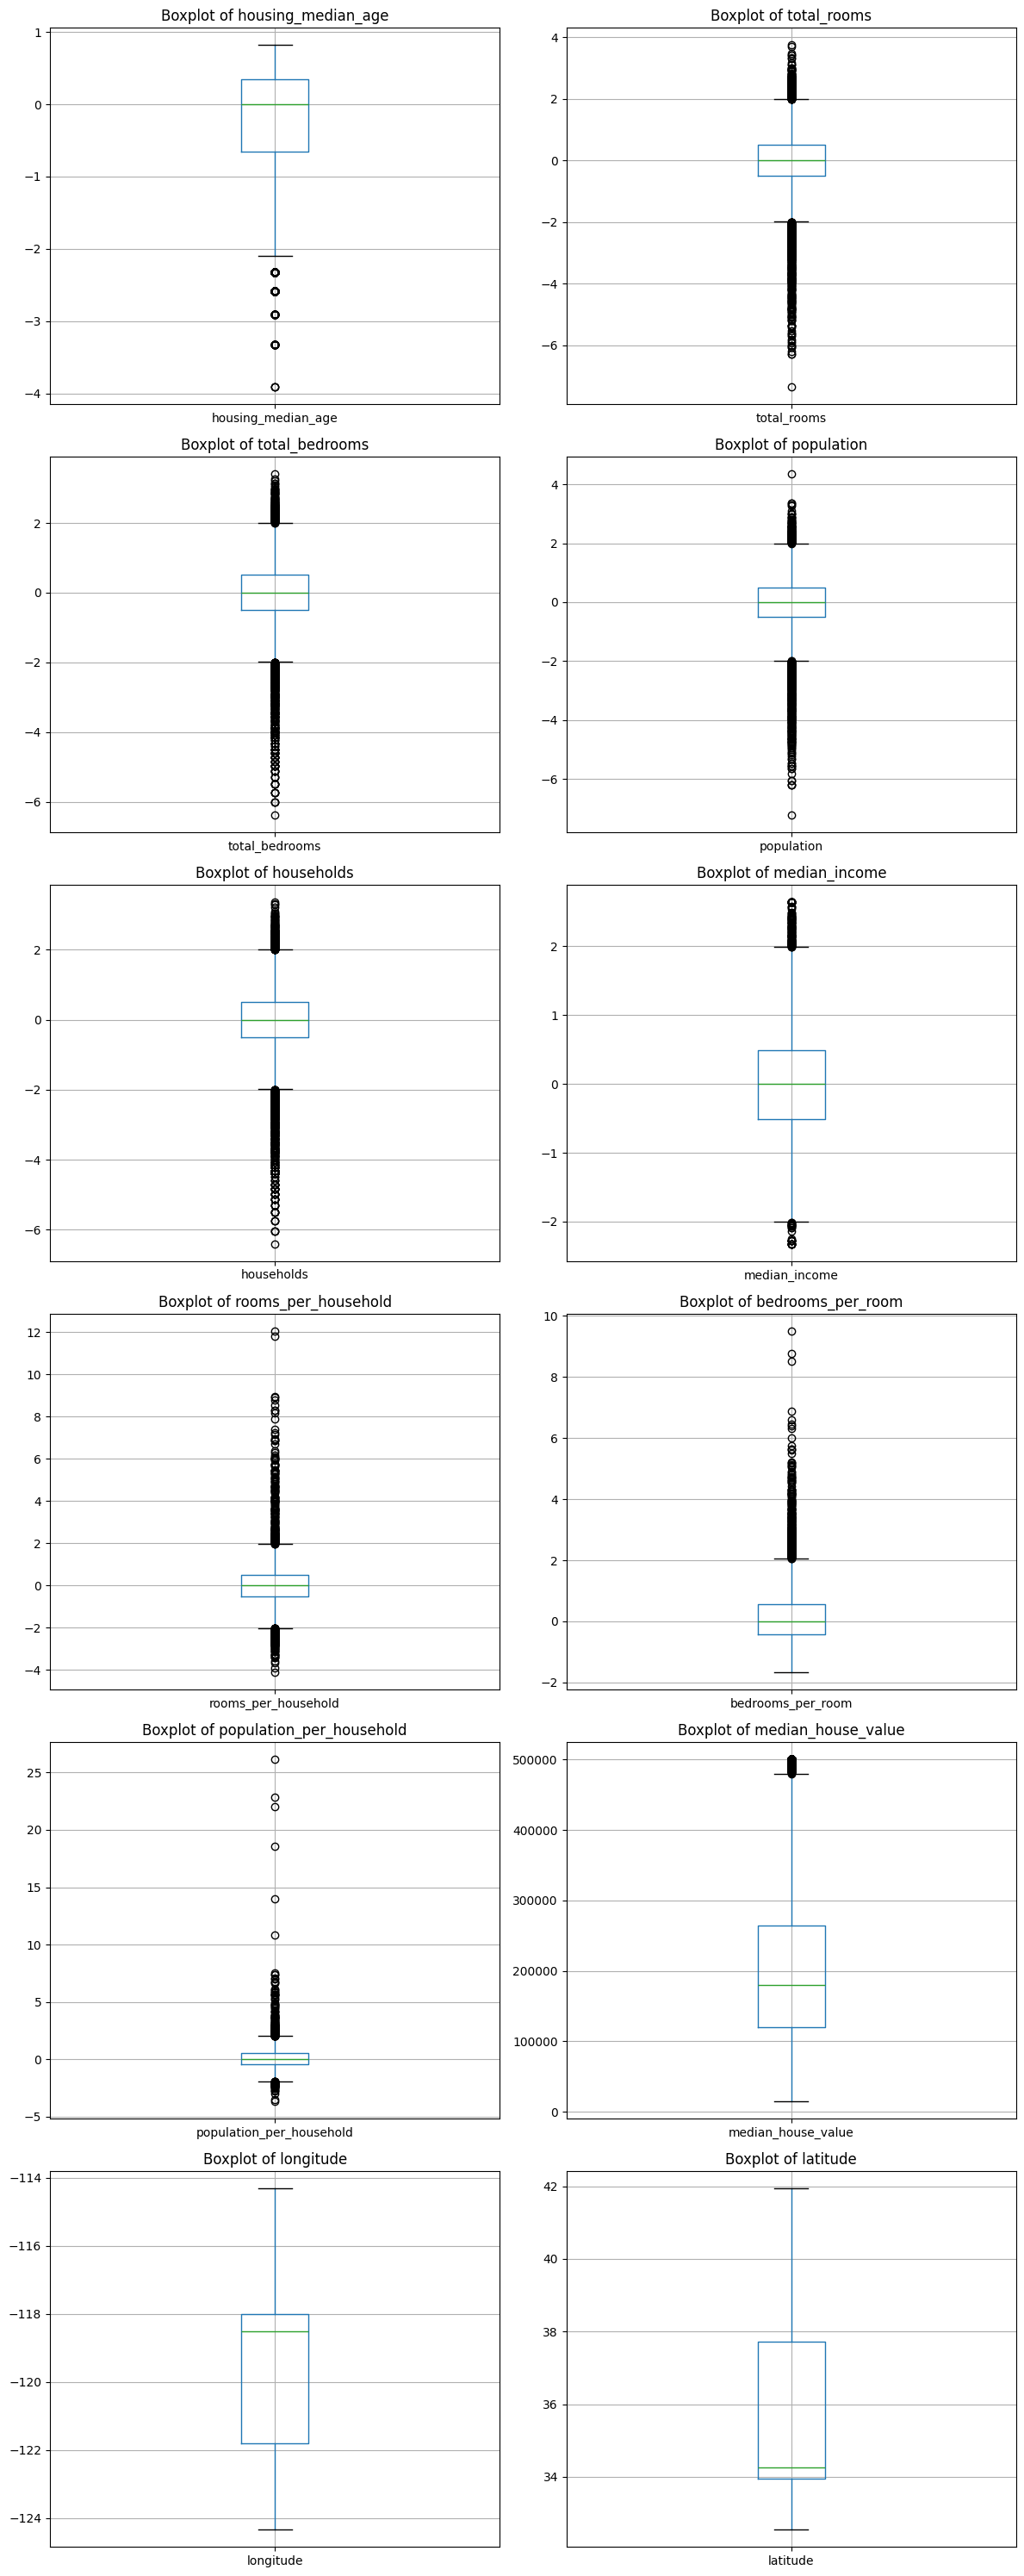

In [58]:
# Select numeric columns
numeric_cols = housing_ready.select_dtypes(include=['float64', 'int64']).columns
num_features = len(numeric_cols)

# Setup 2-column layout
n_cols = 2
n_rows = int(np.ceil(num_features / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5 * n_rows))
axes = axes.flatten()  # flatten to make indexing easier

# Loop and plot each boxplot
for i, col in enumerate(numeric_cols):
    housing_ready.boxplot(column=col, ax=axes[i])
    axes[i].set_title(f"Boxplot of {col}")

# Hide unused subplots (if any)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000
mean,-119.575635,35.639314,28.653404,2622.539789,534.914639,1419.687379,497.011810,3.875884,207005.322372,5.440406,0.212873,3.096469
std,2.001828,2.137963,12.574819,2138.417080,412.665649,1115.663036,375.696156,1.904931,115701.297250,2.611696,0.057378,11.584825
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,1.130435,0.100000,0.692308
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566950,119800.000000,4.442168,0.175304,2.431352
50%,-118.510000,34.260000,29.000000,2119.000000,433.000000,1164.000000,408.000000,3.541550,179500.000000,5.232342,0.203027,2.817661
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.000000,602.000000,4.745325,263900.000000,6.056361,0.239816,3.281420
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


# Data Preprocessing

**0. Copy Strat_train_Set**

In [59]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

**1. Column Transformers for New Features**

In [60]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 12655 to 19773
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16354 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


In [61]:
COL_ROOMS, COL_BEDROOMS, COL_POPULATION, COL_HOUSEHOLDS = "total_rooms", "total_bedrooms", "population", "households"

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        rooms_ix = atribut_columns.index(COL_ROOMS)
        bedrooms_ix = atribut_columns.index(COL_BEDROOMS)
        population_ix = atribut_columns.index(COL_POPULATION)
        households_ix = atribut_columns.index(COL_HOUSEHOLDS)

        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]

        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

atribut_columns = [col for col in housing.columns if col != 'ocean_proximity']

**2. Split Numerical & Categorical**

In [62]:
num_attribs = housing.select_dtypes(include=[np.number]).columns.tolist()
cat_attribs = housing.select_dtypes(exclude=[np.number]).columns.tolist()

**3. Pipeline Initiate**

In [63]:
# Function to apply data transformationg only in positive values.
def safe_log1p(X):
    return np.log1p(np.where(X < 0, 0, X))

In [64]:
# Feature Transform Pipeline
log_scaler_pipeline = Pipeline([
    ('log', FunctionTransformer(safe_log1p, validate=False)),
    ('scaler', RobustScaler())
])

In [65]:
# Number Dtype Pipeline
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('log_and_scale', log_scaler_pipeline)
])

In [66]:
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, atribut_columns),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_attribs)
])

In [67]:
full_pipeline

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('attribs_adder',
                                                  CombinedAttributesAdder()),
                                                 ('log_and_scale',
                                                  Pipeline(steps=[('log',
                                                                   FunctionTransformer(func=<function safe_log1p at 0x7d1c46df4360>)),
                                                                  ('scaler',
                                                                   RobustScaler())]))]),
                                 ['longitude', 'latitude', 'housing_median_age',
                                  'total_rooms', 'total_bedrooms', 'population',
                                  'households', 'median_income']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['ocean_proximity'])])

**4. Check Pipeline**

In [68]:
housing_prepared = full_pipeline.fit_transform(housing)

In [69]:
print(housing_prepared[1])

[ 0.         -0.32850264 -1.9068906   1.18368261  0.88113175  0.69912948
  0.82303885  1.00635018  0.92601061 -0.23558868 -0.66459838  0.
  0.          0.          0.          1.        ]


# Modelling

In the modelling section, we train our dataset using several machine learning algorithms: **Linear Regression**, **Decision Tree**, **Random Forest**, and **XGBoost**.

To train the models, we use the `.fit()` method, which allows each algorithm to learn the patterns from the training data. In addition, we apply **cross-validation** to make better use of the dataset by training and validating the model on different subsets sequentially. This helps improve the model's generalizability and avoids overfitting to a single data split.

The algorithms used in this project work as follows:

**How Each Model Works**

**1. Linear Regression**  
- Fits a straight line (or hyperplane) that models the relationship between input features and the target variable.  
- Uses the **least squares method** to minimize the difference between actual and predicted values.  
- Assumes a linear relationship between features and the output.

**2. Decision Tree Regressor**  
- Splits the dataset into branches based on feature values that reduce prediction error (e.g., Mean Squared Error).  
- Builds a tree structure where each internal node represents a decision and each leaf node holds a predicted value.  
- Continues splitting until a stopping criterion is met, such as maximum depth or minimum number of samples.

**3. Random Forest Regressor**  
- An ensemble method that builds multiple Decision Trees using random subsets of data and features.  
- Each tree predicts independently, and the final result is the **average** of all predictions.  
- Helps reduce overfitting and improves accuracy and stability.

**4. XGBoost Regressor**  
- A gradient boosting algorithm that builds trees **sequentially**, where each new tree corrects the errors of the previous ones.  
- Trains on the **residuals** (errors) instead of raw target values and optimizes using **gradient descent**.  
- Includes regularization terms to prevent overfitting and improve general performance, especially on complex datasets.


## **1. Linear Regression**

In [70]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

# Check Prediction
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [ 72285.47957958 308435.63834119 160100.48664415 219858.53985714
 249863.82641791]
Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [71]:
# Evaluate Using MSE & RMSE
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)

print('Mean Squared Error : ', lin_mse)
print('Root Mean Squared Error : ', lin_rmse)

Mean Squared Error :  4806875468.82937
Root Mean Squared Error :  69331.63396912963


## **2. Decision Tree**

In [72]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)

tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)

print('Mean Squared Error : ', tree_mse)
print('Root Mean Squared Error : ', tree_rmse)

Mean Squared Error :  0.0
Root Mean Squared Error :  0.0


model is overfitting, we have to use Cross Validation !

##  **Cross Validation**

### 3. Decision Tree & CV

In [73]:
def display_scores(scores, model_name="Model"):
    print(f"{model_name} CV Results")
    print("Scores (per fold):", np.round(scores, 2))
    print("Mean RMSE:", round(scores.mean(), 2))
    print("Standard Deviation:", round(scores.std(), 2))

In [74]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,scoring="neg_mean_squared_error", cv=5)
tree_rmse_scores = np.sqrt(-scores)

display_scores(scores = tree_rmse_scores, model_name = "Decision Tree")

Decision Tree CV Results
Scores (per fold): [76064.17 76323.92 75276.41 78132.18 77594.02]
Mean RMSE: 76678.14
Standard Deviation: 1041.19


### 4. Random Forrest & CV

In [75]:
forest_reg = RandomForestRegressor()
scores = cross_val_score(forest_reg, housing_prepared, housing_labels,scoring="neg_mean_squared_error", cv=5)
rfscore = np.sqrt(-scores)

display_scores(scores = rfscore, model_name = "Random Forrest")

Random Forrest CV Results
Scores (per fold): [54344.08 54439.99 54538.25 54879.56 55595.29]
Mean RMSE: 54759.43
Standard Deviation: 455.32


### 5. XGBOOST & CV

In [76]:
xgb_model = xgb.XGBRegressor(random_state=42)
scores = cross_val_score(xgb_model, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=5, n_jobs=-1)
xgb_rmse_scores = np.sqrt(-scores)

display_scores(scores = xgb_rmse_scores, model_name = "XGBOOST")

XGBOOST CV Results
Scores (per fold): [54465.33 53665.73 54298.83 54286.27 55981.66]
Mean RMSE: 54539.56
Standard Deviation: 770.82


From the three algorithms we tested — Linear Regression, Decision Tree, and Random Forest — the Random Forest Regressor gave the best performance based on 10-fold cross-validation using Mean Squared Error (MSE).

Therefore, we’ll move forward by training the Random Forest model using .fit() so we can analyze the most important features that influence median_house_value predictions.

## Final Model Selection

In [77]:
# Create Instance For Forest Regressor
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)

# Train model / Fit model to data
forest_reg.fit(housing_prepared, housing_labels)

# Evaluate Model Using MSE and RMSE
rf_housing_predictions = forest_reg.predict(housing_prepared)
rf_mse = mean_squared_error(housing_labels, rf_housing_predictions)
rf_rmse = np.sqrt(rf_mse)

# Cek Fetaure Importance
feature_importances = forest_reg.feature_importances_

print('Mean Squered Error : ', rf_mse)
print('Root Mean Squered Error : ', rf_rmse)
print('Feature Importance : ', feature_importances)

Mean Squered Error :  413037563.30154556
Root Mean Squered Error :  20323.32559650476
Feature Importance :  [0.00000000e+00 7.20576822e-02 5.19523834e-02 1.63534695e-02
 1.56447837e-02 1.45935615e-02 1.47514412e-02 4.81413908e-01
 3.01679014e-02 1.29655763e-01 2.74271330e-02 1.48135062e-03
 1.39487603e-01 1.13701588e-04 1.30376187e-03 3.59555634e-03]


**Compare The Predictions and Actual Labels**

In [78]:
# take data Sample
some_data = housing.iloc[:20]
some_labels = housing_labels.iloc[:20]
some_data_prepared = full_pipeline.transform(some_data)

predictions = forest_reg.predict(some_data_prepared)
labels = list(some_labels)

# Create new df to see the result
comparison_df = pd.DataFrame({
    'Prediction Label': predictions,
    'Real Label': labels
})

comparison_df['Prediction Label'] = comparison_df['Prediction Label'].round(2)
comparison_df['Difference'] = comparison_df['Prediction Label'] - comparison_df['Real Label']


comparison_df

,Prediction Label,Real Label,Difference
0,77556.00,72100.0,5456.00
1,304209.02,279600.0,24609.02
2,82397.00,82700.0,-303.00
3,123552.00,112500.0,11052.00
4,231501.00,238300.0,-6799.00
5,160389.00,165700.0,-5311.00
6,414727.14,412300.0,2427.14
7,325380.00,349600.0,-24220.00
8,192296.00,181300.0,10996.00
9,390130.69,500001.0,-109870.31


**Cek Fitur paling penting dalam memprediksi `Median_House_Value`**

In [79]:
extra_attribs = ['rooms_per_household', 'population_per_household', 'bedrooms_per_room']
num_attribs = atribut_columns + extra_attribs

cat_encoder = full_pipeline.named_transformers_["cat"]
cat_attribs_encoded = list(cat_encoder.get_feature_names_out(cat_attribs))

feature_names = num_attribs + cat_attribs_encoded

importance_df = pd.Series(feature_importances, index=feature_names)
sorted_importance = importance_df.sort_values(ascending=True)

print(sorted_importance)

longitude                     0.000000
ocean_proximity_ISLAND        0.000114
ocean_proximity_NEAR BAY      0.001304
ocean_proximity_<1H OCEAN     0.001481
ocean_proximity_NEAR OCEAN    0.003596
population                    0.014594
households                    0.014751
total_bedrooms                0.015645
total_rooms                   0.016353
bedrooms_per_room             0.027427
rooms_per_household           0.030168
housing_median_age            0.051952
latitude                      0.072058
population_per_household      0.129656
ocean_proximity_INLAND        0.139488
median_income                 0.481414
dtype: float64


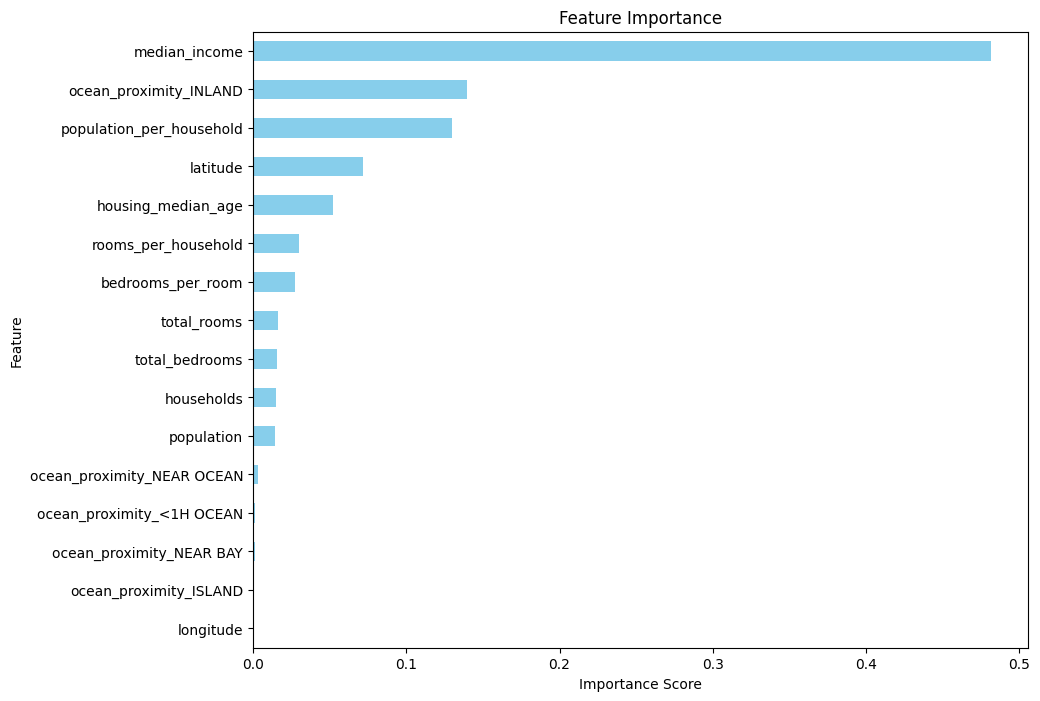

In [80]:
sorted_importance.plot(kind='barh',
                       figsize=(10, 8),
                       title='Feature Importance',
                       color='skyblue')

plt.xlabel('Importance Score')
plt.ylabel('Feature')

plt.show()


Based on the trained Random Forest model, here are the most important insights about which features influence house price predictions:

1. median_income (Median Income)
This is the most impactful feature. It contributes nearly 50% of the model's predictive power. This means the income level in an area has a strong effect on how expensive the houses are.

2. INLAND from ocean_proximity
Geographical location also plays a major role. Specifically, whether a house is located inland or near the ocean matters. Inland areas generally have cheaper houses, and this feature clearly separates landlocked and coastal properties.

3. Engineered Features
Several engineered features, like:

  - population_per_household

  - rooms_per_household

  - bedrooms_per_room

turned out to be more useful than some of the original raw features such as total_rooms or population.

This shows that feature engineering adds value by capturing relationships between variables that are not obvious in raw data.

Summary:

- median_income is the strongest predictor.

- Location (especially INLAND) significantly impacts housing prices.

- Feature-engineered attributes are more insightful than some raw data columns.



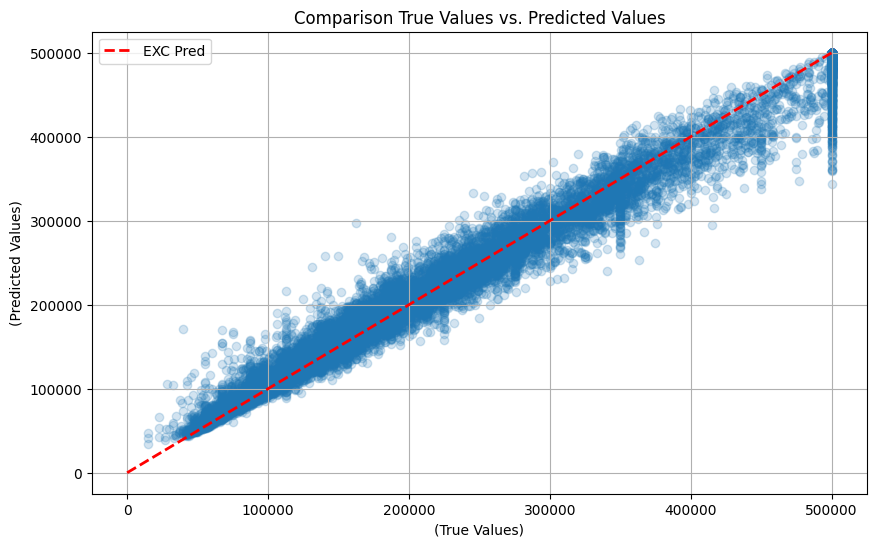

In [81]:
plt.figure(figsize=(10, 6))

plt.scatter(housing_labels, rf_housing_predictions, alpha=0.2)

plt.plot([0, 500000], [0, 500000], '--r', lw=2, label='EXC Pred')

plt.xlabel("(True Values)")
plt.ylabel("(Predicted Values)")
plt.title("Comparison True Values vs. Predicted Values")
plt.legend()
plt.grid()
plt.show()

## Paremeter Tuning

In parameter tuning, we use the best model from the training phase. In this case, we apply **hyperparameter tuning using Bayesian Search** to maximize the performance of the **Random Forest algorithm**.

**Bayesian Search** is a method for **efficiently finding the optimal combination of hyperparameters** by building a probabilistic model of the objective function and using it to select the most promising hyperparameters to try next. Unlike Grid Search or Random Search, Bayesian Search **learns from previous evaluations** and focuses the search on the areas most likely to improve performance.

After finding the best parameters, we **evaluate the optimized model on the test set**, which we prepared at the beginning. This helps us verify how well the model generalizes to unseen data and ensures that our model performs well beyond the training phase.


In [82]:
X = strat_train_set.drop("median_house_value", axis=1)
y = strat_train_set["median_house_value"]

In [83]:
# Final pipeline
final_pipeline = Pipeline([
    ('preprocessing', full_pipeline),
    ('model', RandomForestRegressor(random_state=42))
])

# Define search space for Bayesian Optimization
search_space = {
    'model__n_estimators': Integer(50, 200),
    'model__max_features': Integer(5, 10),
    'model__max_depth': Integer(10, 30)
}

# Setup BayesSearchCV
bayes_search = BayesSearchCV(
    final_pipeline,
    search_spaces=search_space,
    n_iter=10,  # Iteration
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Fit and timing
start = time.time()
print("Start BayesSearchCV...")
bayes_search.fit(X, y)
print("BayesSearchCV Finish.")
end = time.time()
print("Execution Time:", round(end - start, 2), "Second")

# Best model and parameters
final_model = bayes_search.best_estimator_
print('Best Extimator:',  bayes_search.best_params_)


Start BayesSearchCV...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
BayesSearchCV Finish.
Execution Time: 610.65 Second
Best Extimator: OrderedDict([('model__max_depth', 18), ('model__max_features', 9), ('model__n_estimators', 190)])


In [84]:
# Bayesian Search Result
results = pd.DataFrame(bayes_search.cv_results_)
results.sort_values(by="mean_test_score", ascending=False).head(5).T

,0,3,4,6,8
mean_fit_time,28.225855,18.874649,20.465486,17.223499,33.416356
std_fit_time,3.826768,2.769326,4.106018,1.522271,6.119909
mean_score_time,0.246811,0.294083,0.319533,0.171673,0.358285
std_score_time,0.016186,0.093489,0.112246,0.02228,0.103211
param_model__max_depth,18,26,26,22,29
param_model__max_features,9,6,7,9,9
param_model__n_estimators,190,140,129,104,181
params,"{'model__max_depth': 18, 'model__max_features'...","{'model__max_depth': 26, 'model__max_features'...","{'model__max_depth': 26, 'model__max_features'...","{'model__max_depth': 22, 'model__max_features'...","{'model__max_depth': 29, 'model__max_features'..."
split0_test_score,-2926436863.352302,-2941399526.135591,-2937951878.286853,-2923419301.798533,-2923950729.078367
split1_test_score,-2866038474.162464,-2879566674.498162,-2882879237.732828,-2893539929.85163,-2893910089.282198


In [85]:
final_pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('attribs_adder',
                                                                   CombinedAttributesAdder()),
                                                                  ('log_and_scale',
                                                                   Pipeline(steps=[('log',
                                                                                    FunctionTransformer(func=<function safe_log1p at 0x7d1c46df4360>)),
                                                                                   ('scaler',
                                                                                    RobustScaler())]))]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                                                   'median_income']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['ocean_proximity'])])),
                ('model', RandomForestRegressor(random_state=42))])

# Model Evaluation

**1. Split The features & Label in Test Set**

In [86]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

**2. Predict Test Set Using Final Model after Bayesian Optimization**

In [87]:
final_predictions = final_model.predict(X_test)
residuals = y_test - final_predictions

In this step, we evaluate the final model by applying it to the test set.
We use the trained model to predict housing prices on unseen data, then calculate the residuals (i.e., the difference between the actual values and the predicted values).

This helps us assess how well the model generalizes beyond the training data.
By analyzing the residuals, we can understand whether the model is making consistent errors, underpredicting, overpredicting, or struggling in certain price ranges — which is key to determining if the model performs well or needs improvement.

**3. Calculate Evaluation Metrics : MSE, RMSE, R2, MAPE:**

In [88]:
# Calculate MSE & RMSE
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

# Calculate R2
r2 = r2_score(y_test, final_predictions)

# Calculate MAPE
mape = mean_absolute_percentage_error(y_test, final_predictions)

print(f"R² Score on Test Set       : {r2:.4f}")
print(f"MAPE on Test Set           : {mape * 100:.2f}%")
print(f"RMSE on Test Set           : ${final_rmse:,.2f}")

R² Score on Test Set       : 0.7948
MAPE on Test Set           : 20.32%
RMSE on Test Set           : $51,720.04


After fitting the model on the test data, we evaluate its performance using several metrics:

- Mean Squared Error (MSE)

- Root Mean Squared Error (RMSE)

- Mean Absolute Percentage Error (MAPE)

- R² Score (Coefficient of Determination)

These metrics help us understand how accurate the model is in predicting housing prices on unseen data.

**📊 Evaluation Results on Test Set:**

- R² Score: 0.7948 → The model explains about 79.5% of the variance in housing prices.

- MAPE: 20.32% → On average, predictions are off by about 20.32% from the actual values.

- RMSE: 51,720.04 Dollars → The model's prediction error is around $51.7K on average.



**4. Check Residuals**

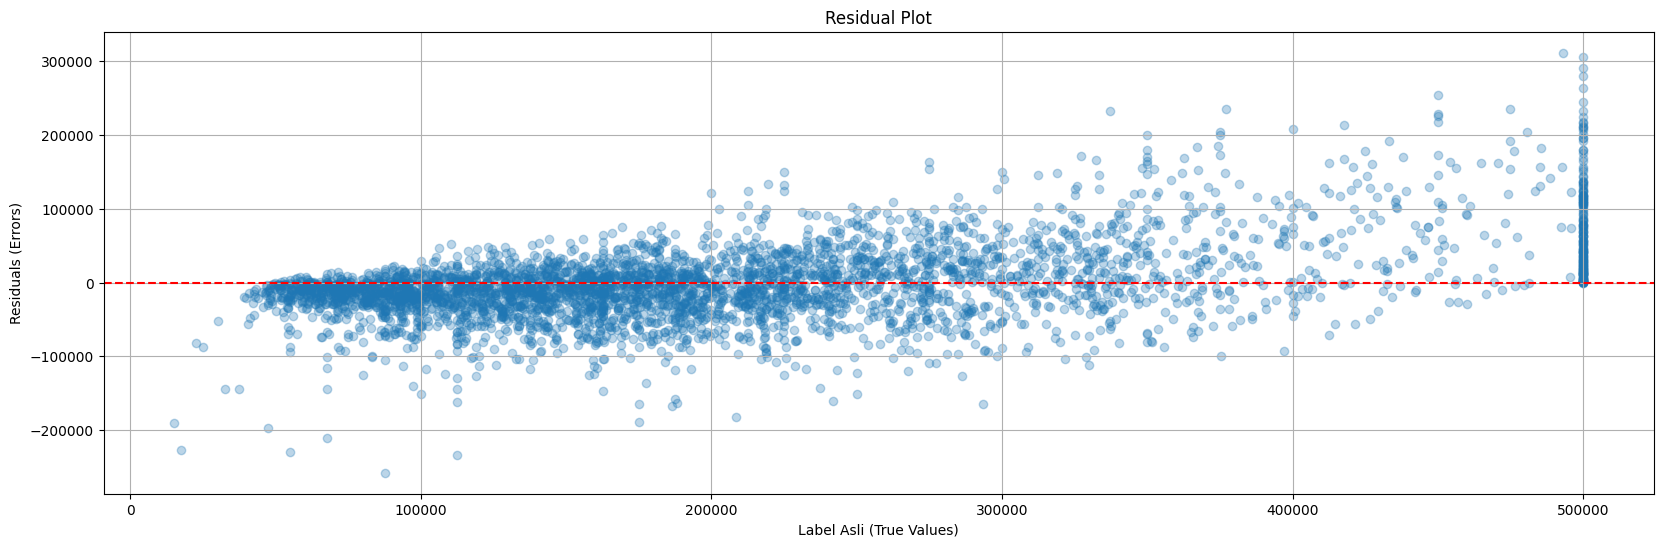

In [89]:
plt.figure(figsize=(20, 6))
plt.scatter(y_test, residuals, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Label Asli (True Values)")
plt.ylabel("Residuals (Errors)")
plt.title("Residual Plot")
plt.grid()
plt.show()

The residual plot provides a visual representation of how well the model predicts the target variable (median_house_value).
The horizontal red line indicates zero residual, meaning the prediction exactly matches the true value.

From the plot, we can observe that for lower to mid-range house values (0 – 250K), the residuals are relatively close to the zero line, indicating good prediction accuracy in that range.

However, as the house value increases, the residuals start to spread out more, showing greater prediction errors. This suggests that the model’s performance tends to decline for higher-priced houses.

**5. True Labels & Predictions Comparison on Data Testing**

In [90]:
# take data Sample
data = X_test.iloc[:20]
labels = y_test.iloc[:20]
data_prepared = full_pipeline.transform(data)

predictions = forest_reg.predict(data_prepared)
labels = list(labels)

# Create new df to see the result
comparison_df = pd.DataFrame({
    'Prediction Label': predictions,
    'Real Label': labels
})

comparison_df['Prediction Label'] = comparison_df['Prediction Label'].round(2)
comparison_df['Difference'] = comparison_df['Prediction Label'] - comparison_df['Real Label']


comparison_df

,Prediction Label,Real Label,Difference
0,478524.68,500001.0,-21476.32
1,214800.03,162500.0,52300.03
2,204728.00,204600.0,128.00
3,143598.00,159700.0,-16102.00
4,295188.03,184000.0,111188.03
5,160047.00,151900.0,8147.00
6,115010.00,104900.0,10110.00
7,401004.09,500001.0,-98996.91
8,209343.01,367400.0,-158056.99
9,317472.10,346500.0,-29027.90


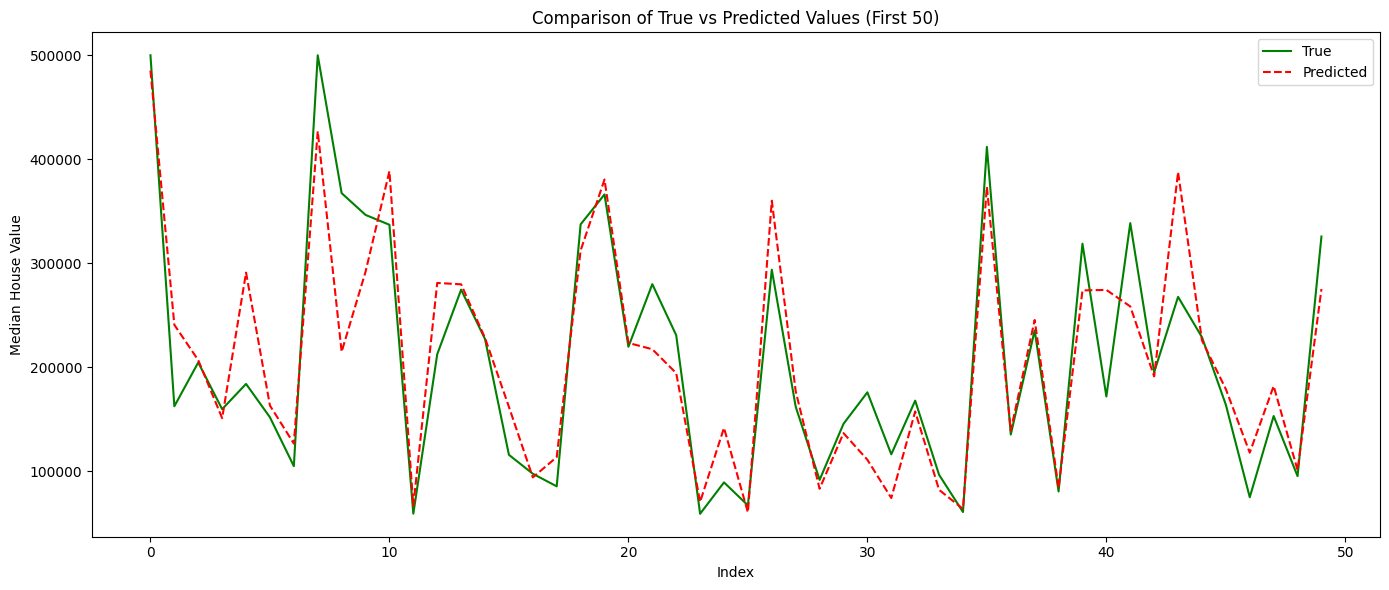

In [91]:
plt.figure(figsize=(14, 6))
plt.plot(y_test.values[:50], label="True", color ='green')
plt.plot(final_predictions[:50], label="Predicted", color= 'red', linestyle = '--')
plt.title("Comparison of True vs Predicted Values (First 50)")
plt.xlabel("Index")
plt.ylabel("Median House Value")
plt.legend()
plt.tight_layout()
plt.show()


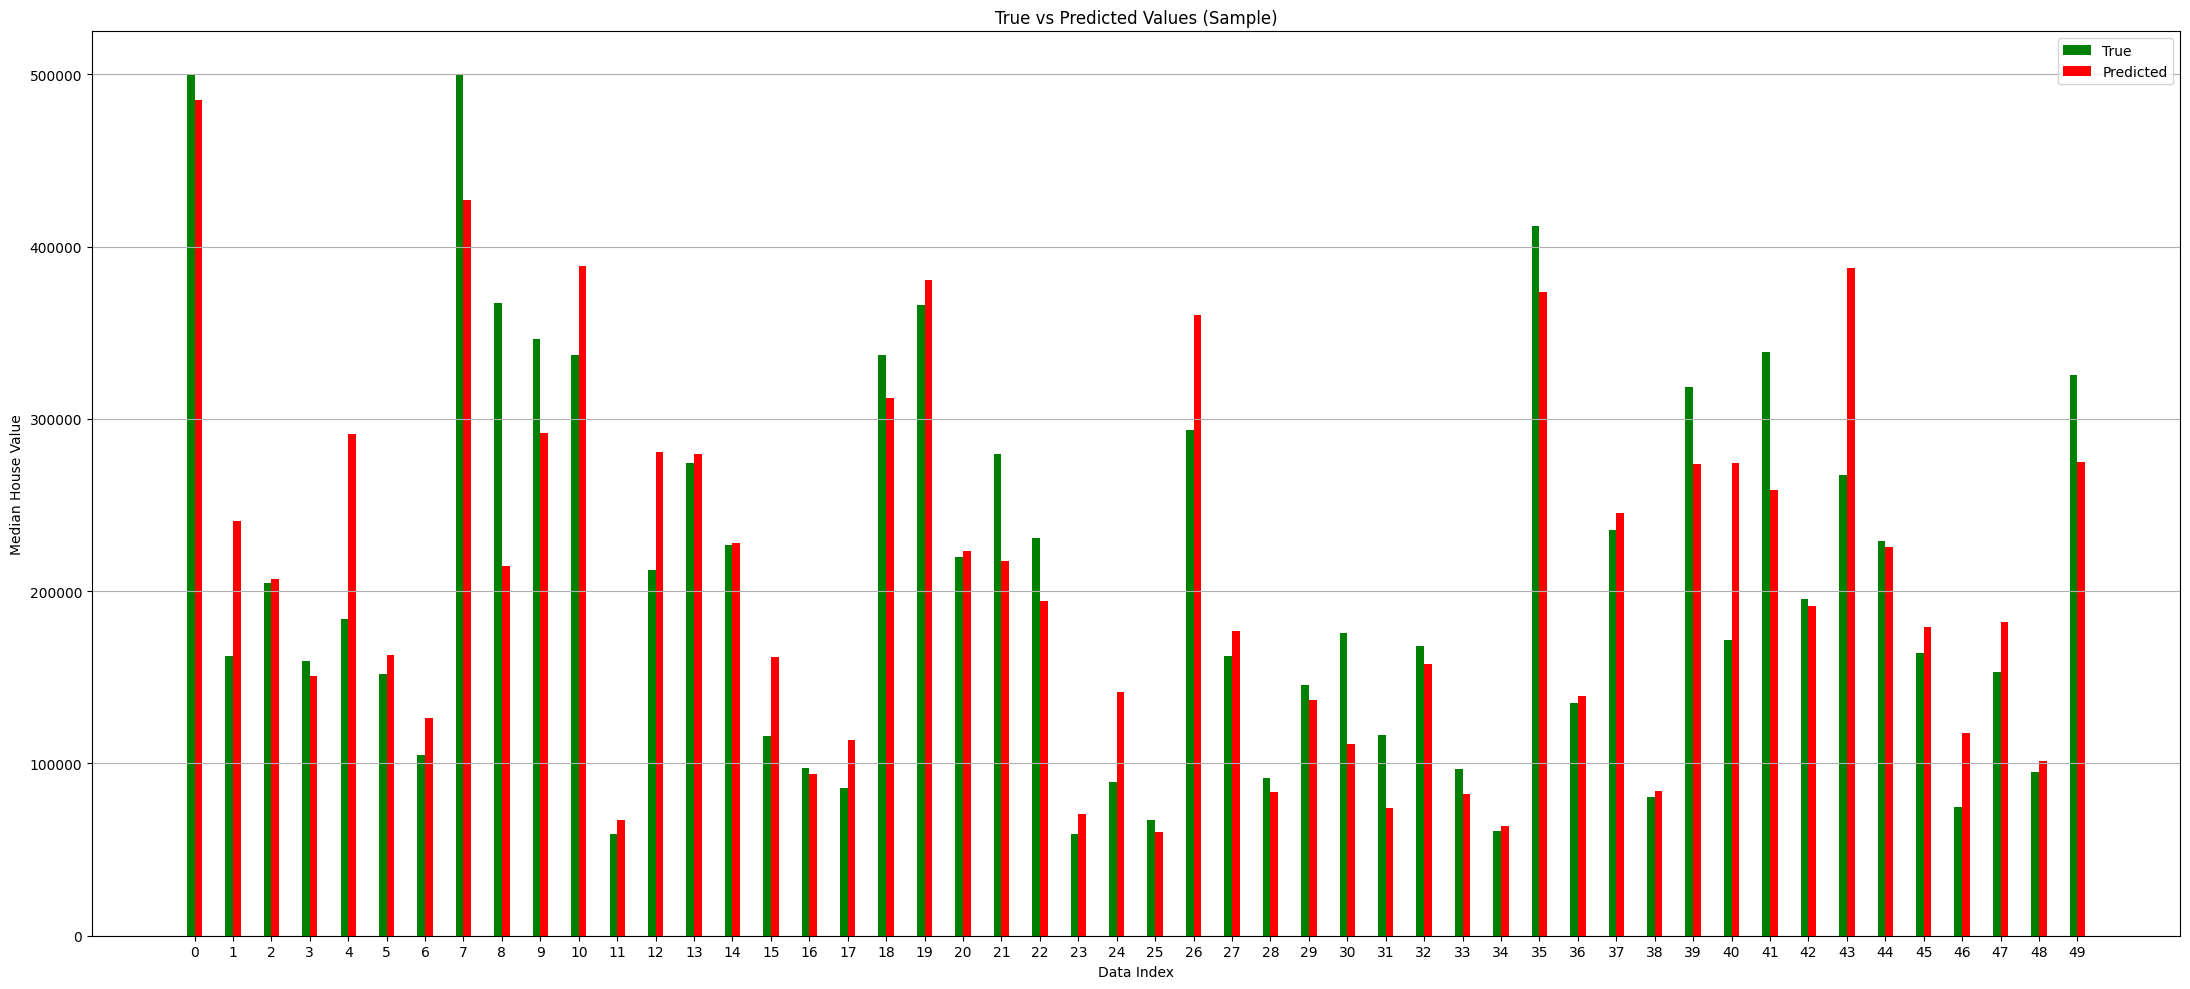

In [92]:
n = 50
sample_preds = final_predictions[:n]
sample_true = y_test[:n].values

x = np.arange(n)
width = 0.20

plt.figure(figsize=(22, 10))
plt.bar(x - width/2, sample_true, width, label='True', color = 'green')
plt.bar(x + width/2, sample_preds, width, label='Predicted', color = 'red')
plt.xlabel("Data Index")
plt.ylabel("Median House Value")
plt.title("True vs Predicted Values (Sample)")
plt.legend()
plt.xticks(x)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


Based on the DataFrame, line plot, and bar plot comparing predictions and true labels, it's evident that there are still many predictions that deviate significantly from the actual values.
This indicates that the model, although already optimized using Bayesian Search and built with one of the best-performing algorithms, still struggles to make accurate predictions consistently.

- The large gaps between predicted and actual values suggest that:

- The model has not fully captured the underlying patterns in the data.

- There might still be important features missing or non-linear relationships that are not well modeled.

- Or the data itself may contain outliers or capped values (e.g. at $500K), which can limit the model's learning ability.

**6. Feature Importance**

median_income                 0.395932
ocean_proximity_INLAND        0.167118
population_per_household      0.122771
latitude                      0.068982
bedrooms_per_room             0.058234
housing_median_age            0.052670
rooms_per_household           0.052137
total_rooms                   0.018092
total_bedrooms                0.018025
population                    0.017722
households                    0.016546
ocean_proximity_<1H OCEAN     0.005697
ocean_proximity_NEAR OCEAN    0.003582
ocean_proximity_NEAR BAY      0.002374
ocean_proximity_ISLAND        0.000117
longitude                     0.000000
dtype: float64


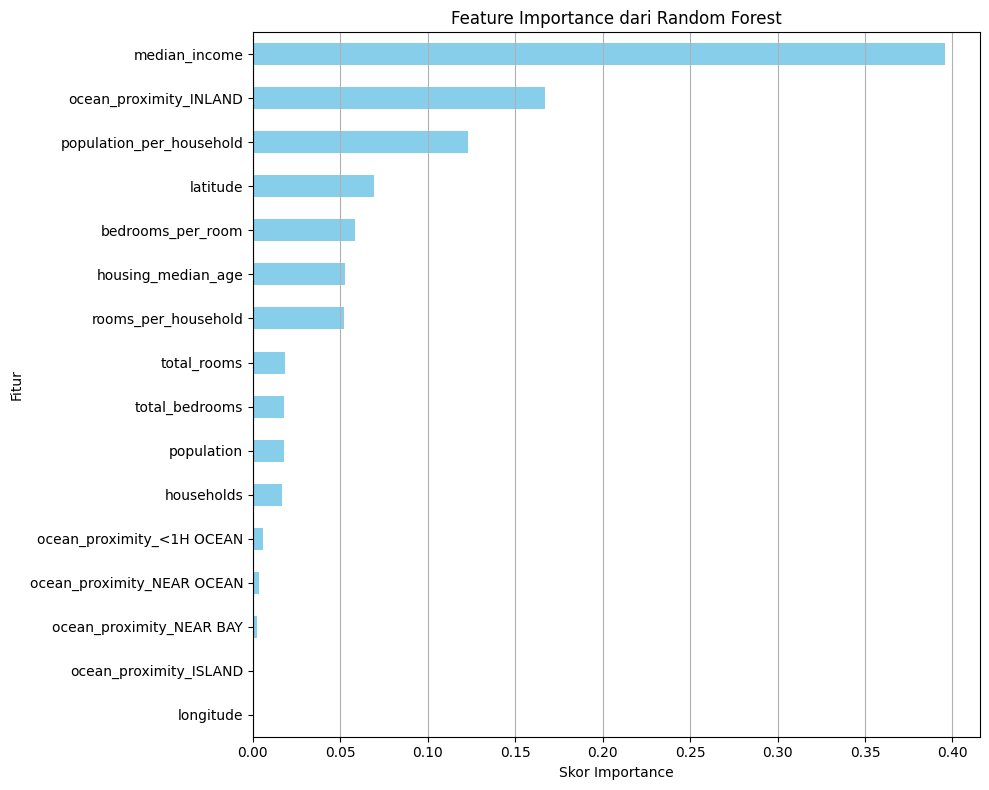

In [93]:
best_rf_model = final_model.named_steps["model"]

extra_attribs = ['rooms_per_household', 'population_per_household', 'bedrooms_per_room']
num_attribs = atribut_columns + extra_attribs

cat_encoder = final_model.named_steps["preprocessing"].named_transformers_["cat"]
cat_attribs_encoded = list(cat_encoder.get_feature_names_out(cat_attribs))

# Combine All Feature
all_feature_names = num_attribs + cat_attribs_encoded


# Check Feature Importance
feature_importances = best_rf_model.feature_importances_

# 5. Create Pandas Series to Know the Feature
importance_df = pd.Series(feature_importances, index=all_feature_names)
sorted_importance = importance_df.sort_values(ascending=True)
print(sorted_importance.sort_values(ascending=False))

# 6. Plot
plt.figure(figsize=(10, 8))
sorted_importance.plot(kind='barh', color='skyblue')
plt.title("Feature Importance dari Random Forest")
plt.xlabel("Skor Importance")
plt.ylabel("Fitur")
plt.tight_layout()
plt.grid(axis='x')
plt.show()

**Feature Importance (After Bayesian Optimization)**

Below is the feature importance ranking based on the optimized **Random Forest Regressor**:

| Feature                       | Importance Score |
|------------------------------|------------------|
| `median_income`              | 0.3959           |
| `ocean_proximity_INLAND`     | 0.1671           |
| `population_per_household`   | 0.1228           |
| `latitude`                   | 0.0690           |
| `bedrooms_per_room`          | 0.0582           |
| `housing_median_age`         | 0.0527           |
| `rooms_per_household`        | 0.0521           |
| `total_rooms`                | 0.0181           |
| `total_bedrooms`             | 0.0180           |
| `population`                 | 0.0177           |
| `households`                 | 0.0165           |
| `ocean_proximity_<1H OCEAN`  | 0.0057           |
| `ocean_proximity_NEAR OCEAN` | 0.0036           |
| `ocean_proximity_NEAR BAY`   | 0.0024           |
| `ocean_proximity_ISLAND`     | 0.0001           |
| `longitude`                  | 0.0000           |

**Interpretation:**
- **`median_income`** is by far the most influential feature in predicting median house prices, contributing nearly **40%** to the model’s decisions.
- Geographic features like `latitude` and `ocean_proximity_INLAND` are also quite significant, especially in capturing **location-based price trends**.
- Some engineered features like `population_per_household` and `bedrooms_per_room` are also important, showing that **data preprocessing and feature engineering paid off**.
- Features like `longitude` and `ocean_proximity_ISLAND` have negligible impact and might be considered for removal or further analysis in future iterations.

This feature ranking helps us understand **which variables are driving the model’s predictions**, and it can also guide future data collection or simplification efforts.


**Save Model**

In [94]:
import joblib

model_name = 'California_medprice.pkl'
joblib.dump(final_model, model_name)

['California_medprice.pkl']

In [95]:
loadmodel = joblib.load(model_name)

prediction_result = loadmodel.predict(X_test.iloc[:50])
true_labels = y_test.iloc[:50].values

# Create new df to see the result
comparison_df = pd.DataFrame({
    'Prediction Label': prediction_result,
    'Real Label': true_labels
})

comparison_df.sample(10)


,Prediction Label,Real Label
17,113587.085541,85500.0
13,279758.570316,274600.0
23,70549.152663,59100.0
40,274372.110526,171900.0
35,373603.412898,411900.0
18,312238.455784,337400.0
0,485280.555965,500001.0
28,83166.180711,91700.0
43,387705.584568,267700.0
34,63784.153775,60800.0


# Conclusion

The project successfully built and evaluated a regression model to predict California housing prices. The Random Forest Regressor, optimized with Bayesian Search, achieved a reasonable performance :     
* R² Score: 0.7948 → The model explains about 79.5% of the variance in housing prices.

* MAPE: 20.32% → On average, predictions are off by about 20.32% from the actual values.

* RMSE: 51,720.04 Dollars → The model's prediction error is around $51.7K on average.

**Potential areas for future improvement:**

- **Address the target variable capping:** Explore methods to handle or remove the capped values (\$\500,000) if predicting higher-end homes is crucial.
- **Explore other algorithms:** Evaluate advanced models like LightGBM, CatBoost, and also deep learning.
- **More extensive feature engineering:** Create additional features based on geographical clusters or interactions between existing features.
- **Outlier treatment:** Investigate specific strategies to handle outliers beyond Robust Scaling.
- **Collect more data:** Obtain more recent and detailed data if available.